# Mixing two models

> In this notebook, I will use the synthesised data from the Brusselator model and instead use Koch-Meinhardt PDEs to estimate their parameters.

> The Brusselator model writes as
<h3><center>$\partial_t u = D_u (\partial_x^2 + \partial_y^2)u + A - (B+1)u + u^2v$</center></h3>

<h3><center>$\partial_t v = D_v (\partial_x^2 + \partial_y^2)v + Bu - u^2 v$</center></h3>

> And the synthesised data is generated for parameters:

- $D_u = 0.0016, \quad D_v=0.0131$.
- $A = 4.5$.
- $B = 13.29$.

> The Koch-Meinhardt PDEs are

<h3><center>$\partial_t u = D_a (\partial_x^2 + \partial_y^2)u + \rho_u \frac{u^2 v}{1 + \kappa_u u^2} - \mu_u u + \sigma_u$</center></h3>
<h3><center>$\partial_t v = D_s (\partial_x^2 + \partial_y^2)v - \rho_v\frac{u^2 v}{1 + \kappa_u u^2} + \sigma_v$</center></h3>

### The followings are the experiments and their results:

1- The training dataset comprises the last four snapshots of the synthesised data, which are the steady state solutions (asymptotics). The assumption of restricting the data set is based on the fact that the time evolutions of each model must be different due to different terms. So, the steady-state solutions with the same symmetry are the only section of a synthesised dataset that can be used in an inverse mixed problem.

2- Using the original diffusions constants fails since $D_u/D_v \approx 0.12$, while for the Koch-Meinhardt model, the spot pattern (the synthesised data) happens for $D_u/D_v \approx 0.05$ (There might be other ranges, but it is not our concern now, as long as 0.12 does not result in a Turing pattern). As a result, I had to select $D_u$ and $D_v$ such that their ratio is approximately close to $0.05$.

3- The original synthesised dataset (Brusselator) ran over a $32 \times 32$ domains for $L = 0.01$. However, this is not a necessary condition for an inverse problem. As we know, the diffusion coefficients determine the length scale of the pattern, so we can safely set $L$ to an arbitrary value (e.g. in the following experiment $L=1.0$) and set  $D_u$ and $D_v$ such that both ratios of scales satisfy $D_u/D_v \approx 0.05$ and $L=1.0$.

### Results:

1- In the first example, I used $D_u/D_v \approx 0.0125$, which is neither close to the ratio of the original dataset nor the ratios of the Koch-Meinhardt spots. However, the ratio must result in a Turing pattern. By setting $L = 1.0$, Adam optimiser for learning rate 0.0001 and after 55,000 iterations, the model loss converges to around $0.20$ observation RMS error. Using the estimated parameters for the Koch-Meinhardt PDEs results in a labyrinth pattern. Some important observations:
   - Spikes occured for $\alpha = 0.5$ regularisations.
   - The outputs of the trained TINN could not produce perfect outputs, as it is clear from the RMS error of $0.20$ (It might get better for more training iteration).
   - One explanation for poor TINN output after so many iterations is the incompatibility of spots and the diffusion ratio. So, this result shows that it is essential to select the correct ratio.
   
2- In the second example, the ratio was set as $D_u/D_v \approx 0.05$ and $L=32$. Then, using the estimated parameters for the same $L$, the Koch-Meinhardt model produces the spots. Some important observations and considerations

   - Aside from setting the correct $D_u/D_v$ ratio, I used $D_u = 0.02$ and $D_v = 0.4$, and accordingly set $L=32$ and $\Delta = \Delta_{original} \times 200 = 15686$. These values can be increased or decreased together as long as the ratio $D_u/D_v$ remains the same and the length and time scales match the diffusion coefficients. e.g. after setting $L=32$ for the selected diffusion coefficients, I increased the original time length between snapshots of the original dataset by 200 folds to match the values of the length and time scales.
   - In comparison to the original dataset, the produced spots are smaller.
   - After 50,000 iterations, the RMS error is 0.0026, two orders of magnitude smaller than the first test. The lower RMS error can be observed in the output of the PINN compared to the original dataset.
   - There was not any spike all through the training.
   

In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = True
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-08-02 17:33:13.956345: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-08-02 17:33:26.373951: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-08-02 17:33:26.418171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-08-02 17:33:26.418207: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-08-02 17:33:26.420347: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-08-02 17:33:26.422471: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

# Load data from the output of Brusselator model

In [2]:
data_path = os.path.abspath("../turing_Brusselator.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("../turing_t_Brusselator.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
# Thining the dataset
t_star = t_star[-4:]#t_star[20::32]
data = data[..., -4:]#[..., 20::32]

T = t_star.shape[0]    
    
L = 1.0
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = dataset['obs_input']
obs_Y = dataset['obs_output']
pde_X = dataset['pde']


# Test one

#### Running the Koch-Meinhardt's ASDM model with given diffusion constants and an arbitrary space scalse to find other parameters

In [4]:
#layers = [3, 64, 64, 64, 64, 2]
layers = [3, 128, 128, 128, 128, 2]

pinn = tu.NN(layers, lb, ub, dtype=tf.float64)
pde_loss = ASDM(dtype=tf.float64, D_u=0.0025, D_v=0.2, init_value=1.0)
#pde_non_zero = Non_zero_params("ASDM", parameters=[pde_loss.D_u, pde_loss.D_v], print_precision=".10f")

In [5]:
model = tu.TINN(pinn, #tu.TINN_inverse(pinn, 
                pde_loss, 
                #non_zero_loss=pde_non_zero, 
                optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
                alpha = 0.5,
                print_precision=".10f")

In [6]:
results = model.train(epochs=5000,
                      batch_size=len(obs_X)//8,
                      X=obs_X,
                      Y=obs_Y,
                      print_interval=50,
                      stop_threshold=1e-5,
                      shuffle=True,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True
                     )


Start of epoch 0


2022-08-01 23:13:18.846286: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-01 23:13:25.329417: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 22.0059280396
total loss: 45.8598896590, total regularisd loss (sum of batches): 366.8791172718
obs u loss: 36.9860326634, obs v loss: 7.0258235481
pde u loss: 0.7534745989, pde v loss: 1.0945588487
lambda obs u: 1.0000000000, lambda obs v: 1.0000000000
lambda pde u: 1.0000000000, lambda pde v: 1.0000000000
sigma_u: 0.99921 sigma_v: 0.99921 mu_u: 0.99950 rho_u: 1.00016 
rho_v: 0.99969 kappa_u: 1.00007 
Time taken: 16.38s

Start of epoch 50
Training observations acc over epoch: 8.9168300629
total loss: 21.3799081404, total regularisd loss (sum of batches): 529.0256166032
obs u loss: 16.6411680891, obs v loss: 1.1924918396
pde u loss: 2.5074634590, pde v loss: 1.0387847527
lambda obs u: 3.9704820533, lambda obs v: 0.0143791723
lambda pde u: 0.0098760473, lambda pde v: 0.0052627271
sigma_u: 1.00179 sigma_v: 0.99756 mu_u: 0.96368 rho_u: 1.03737 
rho_v: 0.95154 kappa_u: 0.96264 
Time taken: 14.29s

Start of epoch 100
Training observations acc over epoch


Start of epoch 900
Training observations acc over epoch: 8.5716009140
total loss: 17.7598040416, total regularisd loss (sum of batches): 522.8886617509
obs u loss: 16.4062438059, obs v loss: 0.7369581185
pde u loss: 0.2021328334, pde v loss: 0.4144692837
lambda obs u: 3.9840300393, lambda obs v: 0.0125177862
lambda pde u: 0.0004915211, lambda pde v: 0.0029606534
sigma_u: 1.03089 sigma_v: 1.05800 mu_u: 0.84815 rho_u: 1.19969 
rho_v: 0.47201 kappa_u: 1.01640 
Time taken: 9.49s

Start of epoch 950
Training observations acc over epoch: 8.5569715500
total loss: 17.6401262013, total regularisd loss (sum of batches): 523.8544142614
obs u loss: 16.4317752168, obs v loss: 0.6821669690
pde u loss: 0.1587654447, pde v loss: 0.3674185709
lambda obs u: 3.9824499545, lambda obs v: 0.0140725852
lambda pde u: 0.0006080285, lambda pde v: 0.0028694317
sigma_u: 1.03202 sigma_v: 1.06322 mu_u: 0.84341 rho_u: 1.20503 
rho_v: 0.45374 kappa_u: 1.02328 
Time taken: 9.35s

Start of epoch 1000
Training observat


Start of epoch 1800
Training observations acc over epoch: 8.4185924530
total loss: 17.1159401608, total regularisd loss (sum of batches): 517.3493214971
obs u loss: 16.3498497629, obs v loss: 0.4873339812
pde u loss: 0.2194255913, pde v loss: 0.0593308254
lambda obs u: 3.9537471178, lambda obs v: 0.0450249620
lambda pde u: 0.0008450869, lambda pde v: 0.0003828333
sigma_u: 0.97269 sigma_v: 1.12269 mu_u: 0.68654 rho_u: 1.08150 
rho_v: 0.25201 kappa_u: 1.21875 
Time taken: 8.72s

Start of epoch 1850
Training observations acc over epoch: 8.4227676392
total loss: 17.1151708373, total regularisd loss (sum of batches): 517.7014327006
obs u loss: 16.3597982807, obs v loss: 0.4857391643
pde u loss: 0.1975540117, pde v loss: 0.0720793807
lambda obs u: 3.9541657885, lambda obs v: 0.0439548053
lambda pde u: 0.0013444070, lambda pde v: 0.0005349991
sigma_u: 0.96206 sigma_v: 1.11833 mu_u: 0.67269 rho_u: 1.06714 
rho_v: 0.26180 kappa_u: 1.22941 
Time taken: 8.65s

Start of epoch 1900
Training observ


Start of epoch 2650
Training observations acc over epoch: 7.8616642952
total loss: 18.9477899798, total regularisd loss (sum of batches): 481.2560907609
obs u loss: 15.2192973532, obs v loss: 0.5040312766
pde u loss: 2.4314307577, pde v loss: 0.7930305923
lambda obs u: 3.9428332481, lambda obs v: 0.0142169927
lambda pde u: 0.0404281859, lambda pde v: 0.0025215733
sigma_u: 0.41737 sigma_v: 1.01620 mu_u: 0.22244 rho_u: 0.54686 
rho_v: 0.34306 kappa_u: 1.64296 
Time taken: 8.62s

Start of epoch 2700
Training observations acc over epoch: 7.8290581703
total loss: 18.8960062801, total regularisd loss (sum of batches): 474.9599848933
obs u loss: 15.1115483945, obs v loss: 0.5465669553
pde u loss: 2.6082372652, pde v loss: 0.6296536651
lambda obs u: 3.9235876594, lambda obs v: 0.0114343875
lambda pde u: 0.0631825725, lambda pde v: 0.0017953806
sigma_u: 0.35028 sigma_v: 0.98198 mu_u: 0.17094 rho_u: 0.48475 
rho_v: 0.36329 kappa_u: 1.69626 
Time taken: 8.77s

Start of epoch 2750
Training observ


Start of epoch 3500
Training observations acc over epoch: 6.5937747955
total loss: 18.7492509606, total regularisd loss (sum of batches): 384.8516401158
obs u loss: 12.7034031153, obs v loss: 0.4841458670
pde u loss: 4.7140902418, pde v loss: 0.8476117365
lambda obs u: 3.6723004667, lambda obs v: 0.0782790908
lambda pde u: 0.2449772478, lambda pde v: 0.0044431947
sigma_u: 0.00000 sigma_v: 1.00962 mu_u: 0.00000 rho_u: 0.05098 
rho_v: 0.22554 kappa_u: 1.88820 
Time taken: 9.13s

Start of epoch 3550
Training observations acc over epoch: 6.5389723778
total loss: 18.6176144105, total regularisd loss (sum of batches): 374.5700122703
obs u loss: 12.5937174923, obs v loss: 0.4842274134
pde u loss: 4.6768763563, pde v loss: 0.8627931485
lambda obs u: 3.6138412734, lambda obs v: 0.0904146041
lambda pde u: 0.2908872645, lambda pde v: 0.0048568580
sigma_u: 0.00000 sigma_v: 1.00890 mu_u: 0.00000 rho_u: 0.05019 
rho_v: 0.21815 kappa_u: 1.86330 
Time taken: 9.00s

Start of epoch 3600
Training observ


Start of epoch 4400
Training observations acc over epoch: 2.8489034176
total loss: 9.5330945820, total regularisd loss (sum of batches): 125.4758209723
obs u loss: 5.2504492971, obs v loss: 0.4473572422
pde u loss: 3.1569970225, pde v loss: 0.6782910201
lambda obs u: 2.4383619872, lambda obs v: 0.5705888666
lambda pde u: 0.9652164230, lambda pde v: 0.0258327231
sigma_u: 0.00000 sigma_v: 0.83487 mu_u: 0.00000 rho_u: 0.22061 
rho_v: 0.45724 kappa_u: 1.22520 
Time taken: 8.99s

Start of epoch 4450
Training observations acc over epoch: 2.6897046566
total loss: 9.4141673765, total regularisd loss (sum of batches): 121.2563973099
obs u loss: 4.9348025056, obs v loss: 0.4446072745
pde u loss: 3.3490365042, pde v loss: 0.6857210922
lambda obs u: 2.4513825654, lambda obs v: 0.7548939681
lambda pde u: 0.7630850254, lambda pde v: 0.0306384412
sigma_u: 0.00000 sigma_v: 0.84586 mu_u: 0.00000 rho_u: 0.22215 
rho_v: 0.47140 kappa_u: 1.20258 
Time taken: 9.07s

Start of epoch 4500
Training observatio

In [16]:
results2 = model.train(epochs=10000,
                      batch_size=len(obs_X)//8,
                      X=obs_X,
                      Y=obs_Y,
                      print_interval=200,
                      stop_threshold=1e-5,
                      shuffle=True,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True
                     )


Start of epoch 0
Training observations acc over epoch: 2.0028381348
total loss: 7.4088730312, total regularisd loss (sum of batches): 81.1130101110
obs u loss: 3.5820586772, obs v loss: 0.4236179429
pde u loss: 2.7881063340, pde v loss: 0.6150900771
lambda obs u: 2.0870666794, lambda obs v: 1.0904770568
lambda pde u: 0.7801601186, lambda pde v: 0.0422961451
sigma_u: 0.0000000000 sigma_v: 1.0847358581 mu_u: 0.0000000000 rho_u: 0.2219145907 
rho_v: 0.4951014183 kappa_u: 0.9837116990 
Time taken: 0.23s

Start of epoch 200
Training observations acc over epoch: 1.9241394997
total loss: 6.8025635179, total regularisd loss (sum of batches): 71.1984052785
obs u loss: 3.4272818709, obs v loss: 0.4209971346
pde u loss: 2.3284140901, pde v loss: 0.6258704223
lambda obs u: 1.7251386283, lambda obs v: 1.2467983414
lambda pde u: 0.9758431350, lambda pde v: 0.0522198953
sigma_u: 0.0000000000 sigma_v: 1.1621862054 mu_u: 0.0000000000 rho_u: 0.2201443418 
rho_v: 0.4910412195 kappa_u: 0.9008562742 
Time


Start of epoch 3400
Training observations acc over epoch: 0.7188568115
total loss: 3.6386711325, total regularisd loss (sum of batches): 22.5280482486
obs u loss: 1.1531641150, obs v loss: 0.2845496371
pde u loss: 1.5066174461, pde v loss: 0.6943399344
lambda obs u: 1.4216509950, lambda obs v: 2.0615262662
lambda pde u: 0.4121405140, lambda pde v: 0.1046822248
sigma_u: 0.0000000000 sigma_v: 2.5217829894 mu_u: 0.5182900124 rho_u: 0.0566156662 
rho_v: 0.0432668438 kappa_u: 0.0019303296 
Time taken: 36.10s

Start of epoch 3600
Training observations acc over epoch: 0.7131271362
total loss: 3.4713534221, total regularisd loss (sum of batches): 22.5239026858
obs u loss: 1.1451688168, obs v loss: 0.2810854864
pde u loss: 1.3691079732, pde v loss: 0.6759911458
lambda obs u: 1.3488014640, lambda obs v: 2.0942462099
lambda pde u: 0.4530896255, lambda pde v: 0.1038627007
sigma_u: 0.0000000000 sigma_v: 2.6522893693 mu_u: 0.5799779529 rho_u: 0.0607802329 
rho_v: 0.0461329776 kappa_u: 0.0018967620 


Start of epoch 6800
Training observations acc over epoch: 0.4818660617
total loss: 2.7479439479, total regularisd loss (sum of batches): 14.1366613936
obs u loss: 0.7224679440, obs v loss: 0.2412641468
pde u loss: 1.1127062873, pde v loss: 0.6715055698
lambda obs u: 0.9681644836, lambda obs v: 2.7135895155
lambda pde u: 0.2475622190, lambda pde v: 0.0706837820
sigma_u: 0.0000000000 sigma_v: 4.5759158693 mu_u: 1.2830233300 rho_u: 0.1059533447 
rho_v: 0.0746727348 kappa_u: 0.0019323622 
Time taken: 36.53s

Start of epoch 7000
Training observations acc over epoch: 0.4707907736
total loss: 3.0246393675, total regularisd loss (sum of batches): 14.4087673314
obs u loss: 0.7022710043, obs v loss: 0.2393105067
pde u loss: 1.1696636708, pde v loss: 0.9133941857
lambda obs u: 1.0552318310, lambda obs v: 2.6212630230
lambda pde u: 0.2497535770, lambda pde v: 0.0737515690
sigma_u: 0.0000000000 sigma_v: 4.6751989785 mu_u: 1.3073698876 rho_u: 0.1077994092 
rho_v: 0.0763237196 kappa_u: 0.0019161285 

In [26]:
results3 = model.train(epochs=10000,
                      batch_size=len(obs_X)//8,
                      X=obs_X,
                      Y=obs_Y,
                      print_interval=200,
                      stop_threshold=1e-5,
                      shuffle=True,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True
                     )


Start of epoch 0
Training observations acc over epoch: 0.3804114461
total loss: 2.2561267865, total regularisd loss (sum of batches): 11.1577119122
obs u loss: 0.5408118772, obs v loss: 0.2200109872
pde u loss: 0.9049527716, pde v loss: 0.5903511505
lambda obs u: 0.9830784927, lambda obs v: 2.6911878033
lambda pde u: 0.2500473818, lambda pde v: 0.0756863222
sigma_u: 0.0000000000 sigma_v: 5.8794600767 mu_u: 1.5139491829 rho_u: 0.1229939436 
rho_v: 0.0923442232 kappa_u: 0.0020361558 
Time taken: 0.26s

Start of epoch 200
Training observations acc over epoch: 0.3710635900
total loss: 2.2296892517, total regularisd loss (sum of batches): 10.6404851668
obs u loss: 0.5238948393, obs v loss: 0.2182323453
pde u loss: 0.8964597421, pde v loss: 0.5911023250
lambda obs u: 0.9590509871, lambda obs v: 2.7211188625
lambda pde u: 0.2391663069, lambda pde v: 0.0806638435
sigma_u: 0.0000000000 sigma_v: 5.9438138221 mu_u: 1.5236725582 rho_u: 0.1236127267 
rho_v: 0.0934575105 kappa_u: 0.0020352078 
Time

lambda pde u: 0.2089094427, lambda pde v: 0.0746129440
sigma_u: 0.0000000000 sigma_v: 6.4904626610 mu_u: 1.6418605830 rho_u: 0.1318675260 
rho_v: 0.1019507000 kappa_u: 0.0020644952 
Time taken: 35.59s

Start of epoch 3400
Training observations acc over epoch: 0.3413353562
total loss: 1.9911245441, total regularisd loss (sum of batches): 9.8492499298
obs u loss: 0.4736706554, obs v loss: 0.2090000434
pde u loss: 0.7866761323, pde v loss: 0.5217777131
lambda obs u: 0.9431614532, lambda obs v: 2.8013203119
lambda pde u: 0.1805457448, lambda pde v: 0.0749724901
sigma_u: 0.0000000000 sigma_v: 6.5403307912 mu_u: 1.6472039719 rho_u: 0.1321314363 
rho_v: 0.1026973804 kappa_u: 0.0020783643 
Time taken: 36.88s

Start of epoch 3600
Training observations acc over epoch: 0.3440714777
total loss: 2.2156940611, total regularisd loss (sum of batches): 9.5874719632
obs u loss: 0.4797961712, obs v loss: 0.2083467383
pde u loss: 0.8379392275, pde v loss: 0.6896119241
lambda obs u: 0.7607053017, lambda ob


Start of epoch 6600
Training observations acc over epoch: 0.3145904839
total loss: 2.0456977615, total regularisd loss (sum of batches): 9.1392814006
obs u loss: 0.4297737028, obs v loss: 0.1994073110
pde u loss: 0.7790328473, pde v loss: 0.6374839005
lambda obs u: 0.7707314122, lambda obs v: 2.9904436875
lambda pde u: 0.1724715301, lambda pde v: 0.0663533702
sigma_u: 0.0000000000 sigma_v: 6.9434067872 mu_u: 1.7147551398 rho_u: 0.1375755012 
rho_v: 0.1103470608 kappa_u: 0.0020754115 
Time taken: 35.21s

Start of epoch 6800
Training observations acc over epoch: 0.3097422421
total loss: 2.0126426349, total regularisd loss (sum of batches): 9.2927939680
obs u loss: 0.4203573708, obs v loss: 0.1991271522
pde u loss: 0.7994313019, pde v loss: 0.5937268100
lambda obs u: 0.9247747269, lambda obs v: 2.8442895825
lambda pde u: 0.1578281630, lambda pde v: 0.0731075276
sigma_u: 0.0000000000 sigma_v: 6.9824883479 mu_u: 1.7169115210 rho_u: 0.1380275282 
rho_v: 0.1106530915 kappa_u: 0.0020743343 
T

In [61]:
results4 = model.train(epochs=20000,
                      batch_size=len(obs_X)//8,
                      X=obs_X,
                      Y=obs_Y,
                      print_interval=200,
                      stop_threshold=1e-5,
                      shuffle=True,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True
                     )


Start of epoch 0
Training observations acc over epoch: 0.2867413163
total loss: 2.2597455496, total regularisd loss (sum of batches): 8.8170340276
obs u loss: 0.3810529424, obs v loss: 0.1924297184
pde u loss: 0.7477119248, pde v loss: 0.9385509641
lambda obs u: 0.9682781052, lambda obs v: 2.7864823686
lambda pde u: 0.1740093585, lambda pde v: 0.0712301678
sigma_u: 0.0000000000 sigma_v: 7.2591260975 mu_u: 1.7123473906 rho_u: 0.1416252490 
rho_v: 0.1175425087 kappa_u: 0.0022780960 
Time taken: 0.25s

Start of epoch 200
Training observations acc over epoch: 0.2973504663
total loss: 1.6388190179, total regularisd loss (sum of batches): 9.1723101662
obs u loss: 0.3928944299, obs v loss: 0.2018064901
pde u loss: 0.6121159726, pde v loss: 0.4320021253
lambda obs u: 0.9733980982, lambda obs v: 2.6331428138
lambda pde u: 0.2610324929, lambda pde v: 0.1324265950
sigma_u: 0.0000000000 sigma_v: 7.2336387318 mu_u: 1.7142653605 rho_u: 0.1428815428 
rho_v: 0.1136262309 kappa_u: 0.0025359914 
Time t

total loss: 1.4467687570, total regularisd loss (sum of batches): 7.9473339595
obs u loss: 0.3477383701, obs v loss: 0.1928384690
pde u loss: 0.5331141179, pde v loss: 0.3730778000
lambda obs u: 0.9500532136, lambda obs v: 2.7811224806
lambda pde u: 0.1913732788, lambda pde v: 0.0774510269
sigma_u: 0.0000000000 sigma_v: 7.5177373694 mu_u: 1.6163446216 rho_u: 0.1419996224 
rho_v: 0.1192488013 kappa_u: 0.0027138808 
Time taken: 36.58s

Start of epoch 3400
Training observations acc over epoch: 0.2655611336
total loss: 1.4447159855, total regularisd loss (sum of batches): 7.8492664438
obs u loss: 0.3408613876, obs v loss: 0.1902608688
pde u loss: 0.5440108564, pde v loss: 0.3695828727
lambda obs u: 1.0078305608, lambda obs v: 2.7162765089
lambda pde u: 0.1702348998, lambda pde v: 0.1056580305
sigma_u: 0.0000000000 sigma_v: 7.5165016642 mu_u: 1.6088632497 rho_u: 0.1412873050 
rho_v: 0.1206288712 kappa_u: 0.0026249041 
Time taken: 35.82s

Start of epoch 3600
Training observations acc over ep


Start of epoch 6600
Training observations acc over epoch: 0.2626136243
total loss: 1.6437452453, total regularisd loss (sum of batches): 8.5297824325
obs u loss: 0.3333337211, obs v loss: 0.1918935632
pde u loss: 0.5507970255, pde v loss: 0.5677209356
lambda obs u: 1.0017143158, lambda obs v: 2.6265206910
lambda pde u: 0.2283940144, lambda pde v: 0.1433709788
sigma_u: 0.0000000000 sigma_v: 7.7340731650 mu_u: 1.4841972182 rho_u: 0.1383999572 
rho_v: 0.1271205276 kappa_u: 0.0030932613 
Time taken: 33.93s

Start of epoch 6800
Training observations acc over epoch: 0.2516727448
total loss: 1.3666095059, total regularisd loss (sum of batches): 7.5967079718
obs u loss: 0.3159262063, obs v loss: 0.1874193237
pde u loss: 0.4735948425, pde v loss: 0.3896691334
lambda obs u: 0.9326703102, lambda obs v: 2.7078989713
lambda pde u: 0.2596827121, lambda pde v: 0.0997480064
sigma_u: 0.0000000000 sigma_v: 7.7309978591 mu_u: 1.4824702539 rho_u: 0.1380189733 
rho_v: 0.1268903034 kappa_u: 0.0029041283 
T


Start of epoch 10000
Training observations acc over epoch: 0.2336512059
total loss: 1.4193183548, total regularisd loss (sum of batches): 7.1925180427
obs u loss: 0.2917919756, obs v loss: 0.1755104369
pde u loss: 0.4712077360, pde v loss: 0.4808082063
lambda obs u: 0.9052514687, lambda obs v: 2.8419103584
lambda pde u: 0.1855026433, lambda pde v: 0.0673355297
sigma_u: 0.0000000000 sigma_v: 7.9385173695 mu_u: 1.3784262427 rho_u: 0.1335650492 
rho_v: 0.1341796456 kappa_u: 0.0028174825 
Time taken: 34.71s

Start of epoch 10200
Training observations acc over epoch: 0.2325570434
total loss: 1.3499995313, total regularisd loss (sum of batches): 6.8231136122
obs u loss: 0.2900477719, obs v loss: 0.1750663382
pde u loss: 0.4718435393, pde v loss: 0.4130418818
lambda obs u: 0.8401854861, lambda obs v: 2.9679841255
lambda pde u: 0.1211033534, lambda pde v: 0.0707270350
sigma_u: 0.0000000000 sigma_v: 7.9723865164 mu_u: 1.3706676791 rho_u: 0.1333804718 
rho_v: 0.1343096908 kappa_u: 0.0028458288 


Start of epoch 13400
Training observations acc over epoch: 0.2248006463
total loss: 1.1658957769, total regularisd loss (sum of batches): 6.6433759393
obs u loss: 0.2746372711, obs v loss: 0.1749640270
pde u loss: 0.3924819203, pde v loss: 0.3238125585
lambda obs u: 0.9211166755, lambda obs v: 2.8162694673
lambda pde u: 0.1724787497, lambda pde v: 0.0901351074
sigma_u: 0.0000000000 sigma_v: 8.1132884169 mu_u: 1.3026446410 rho_u: 0.1318421022 
rho_v: 0.1365894319 kappa_u: 0.0031015634 
Time taken: 36.02s

Start of epoch 13600
Training observations acc over epoch: 0.2226783037
total loss: 1.1670346481, total regularisd loss (sum of batches): 6.6669312743
obs u loss: 0.2722565349, obs v loss: 0.1731000918
pde u loss: 0.3981706074, pde v loss: 0.3235074141
lambda obs u: 0.9053474467, lambda obs v: 2.8489219863
lambda pde u: 0.1637621633, lambda pde v: 0.0819684037
sigma_u: 0.0000000000 sigma_v: 8.1151167708 mu_u: 1.2983204159 rho_u: 0.1313271060 
rho_v: 0.1373505314 kappa_u: 0.0030408078 


Start of epoch 16800
Training observations acc over epoch: 0.2106870264
total loss: 1.2273138879, total regularisd loss (sum of batches): 6.2719306936
obs u loss: 0.2564052601, obs v loss: 0.1649687807
pde u loss: 0.3899624213, pde v loss: 0.4159774258
lambda obs u: 0.8740874278, lambda obs v: 2.8860231131
lambda pde u: 0.1598704938, lambda pde v: 0.0800189653
sigma_u: 0.0000000000 sigma_v: 8.2747668216 mu_u: 1.2319252043 rho_u: 0.1286972096 
rho_v: 0.1435881061 kappa_u: 0.0030198525 
Time taken: 34.88s

Start of epoch 17000
Training observations acc over epoch: 0.2230363339
total loss: 1.3189706076, total regularisd loss (sum of batches): 7.3064055076
obs u loss: 0.2720431374, obs v loss: 0.1740295382
pde u loss: 0.4190367179, pde v loss: 0.4538612140
lambda obs u: 0.9627069697, lambda obs v: 2.5431483544
lambda pde u: 0.3169224251, lambda pde v: 0.1772222508
sigma_u: 0.0000000000 sigma_v: 8.2727953990 mu_u: 1.2313811655 rho_u: 0.1300265490 
rho_v: 0.1410548943 kappa_u: 0.0034584599 

In [62]:
pde_loss.print_precision=".10f"
print(pde_loss.trainables_str())

sigma_u: 0.0000013709 sigma_v: 8.3639623771 mu_u: 1.1747487351 rho_u: 0.1271707249 
rho_v: 0.1457174021 kappa_u: 0.0032018738 


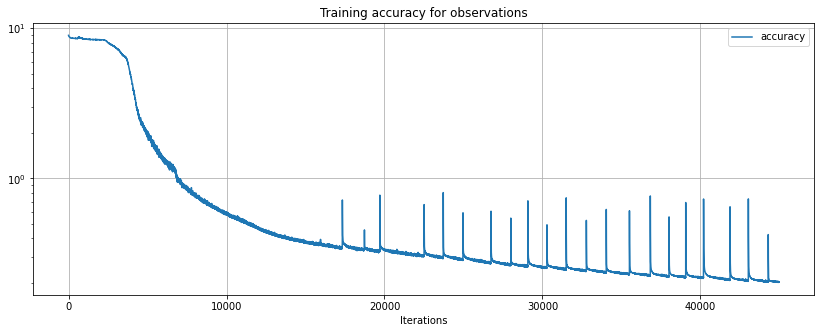

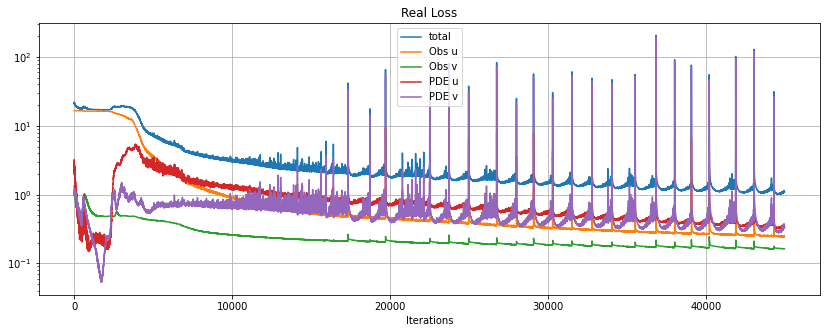

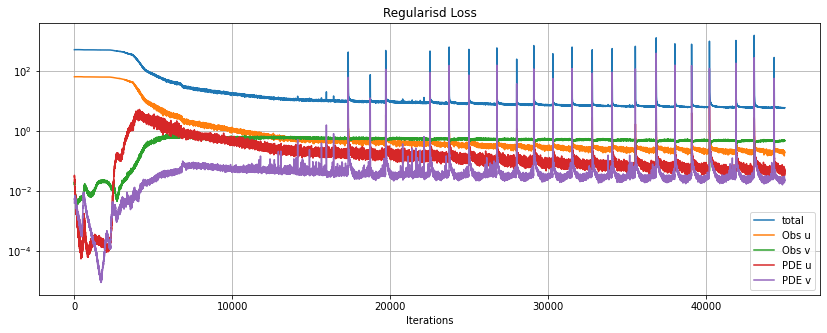

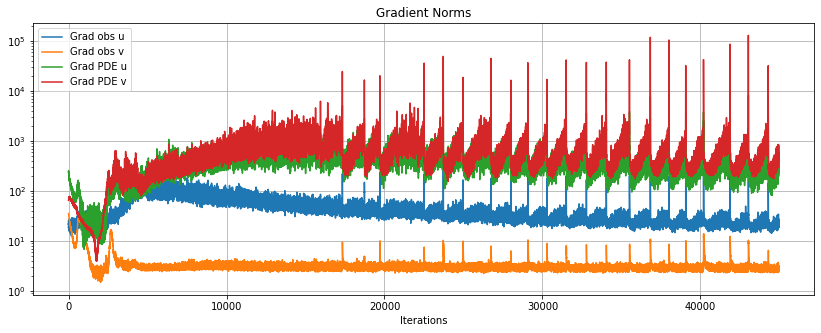

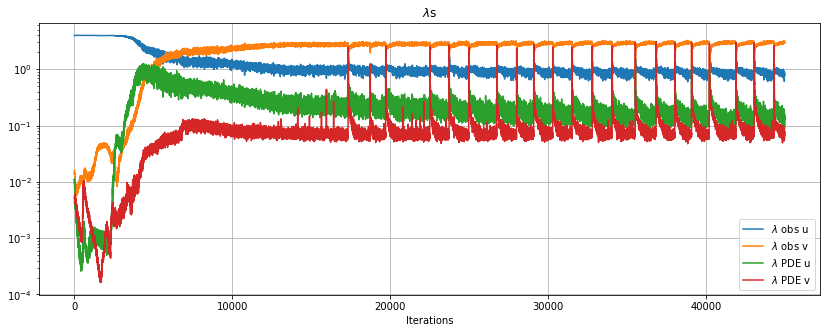

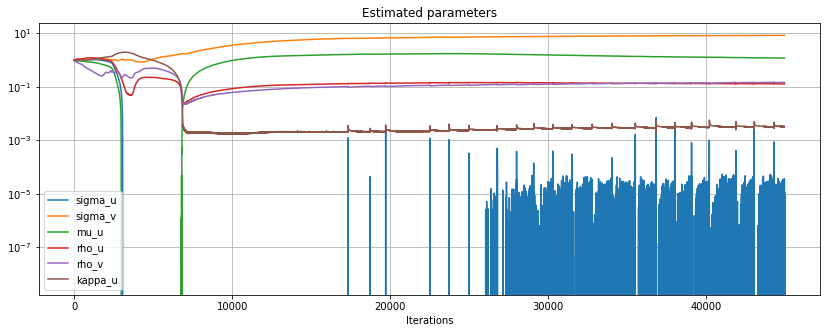

In [63]:
plot_result(merge_dict(results, results2, results3, results4),
            param_names=pde_loss.parameter_names(),  
            start=40,
            #end=2000,
            yscale = 'log')

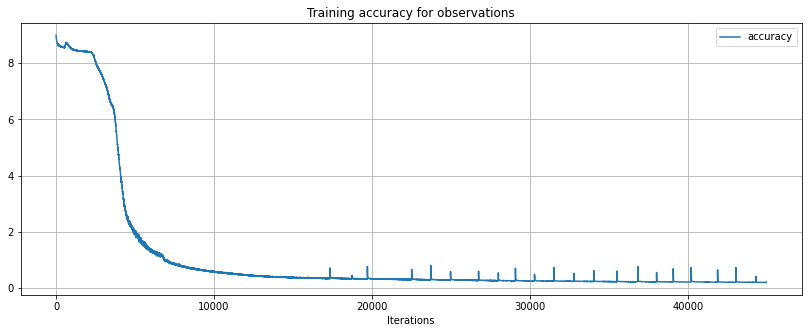

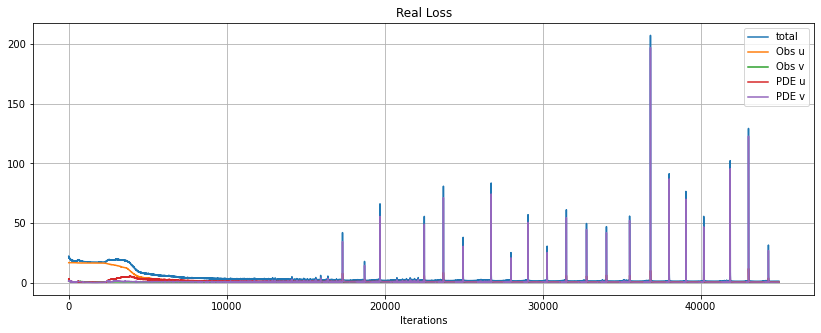

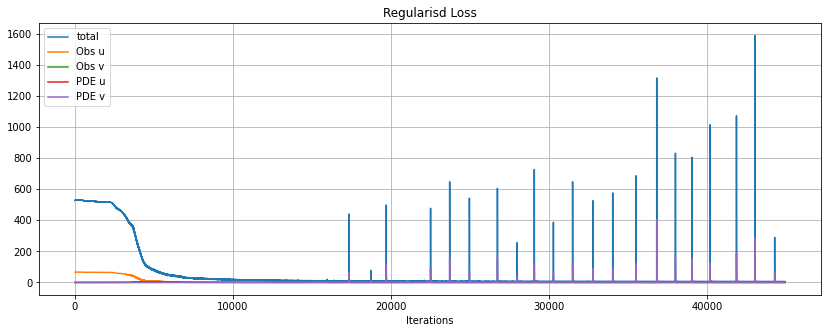

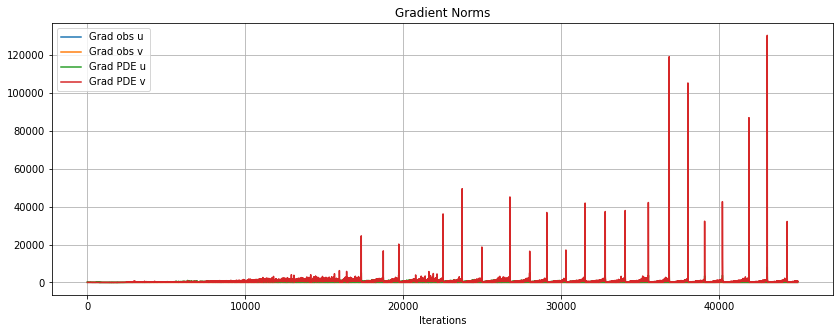

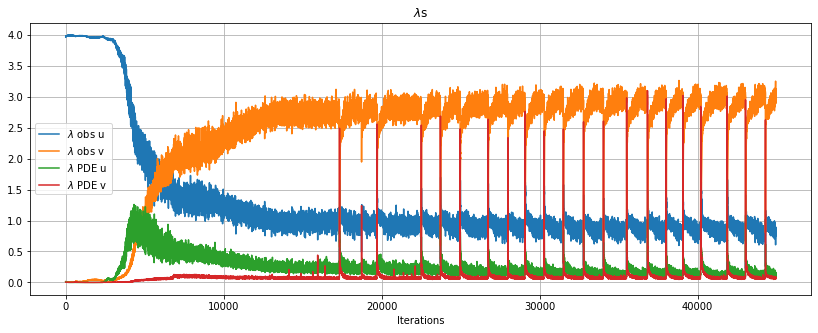

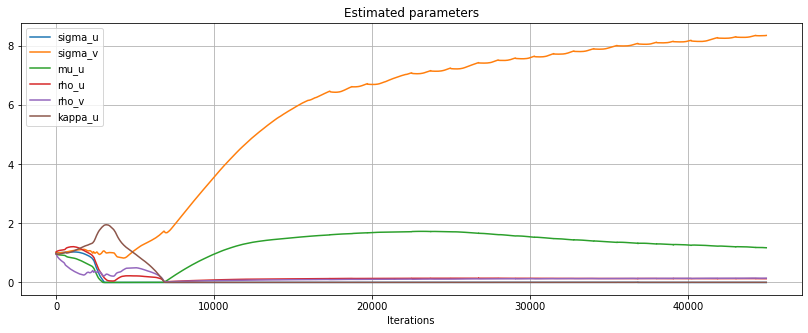

In [64]:
plot_result(merge_dict(results, results2, results3, results4),
            param_names=pde_loss.parameter_names(),  
            start=40,
            yscale = 'linear')

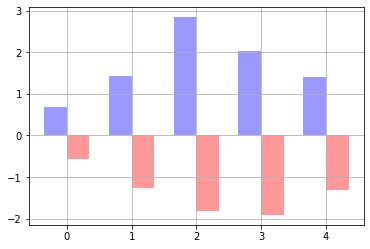

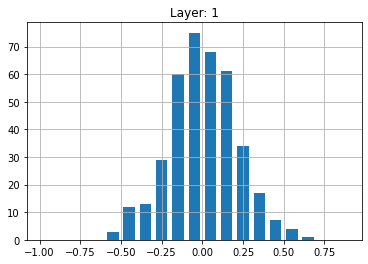

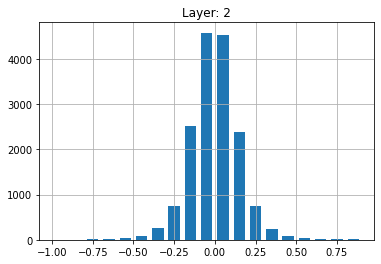

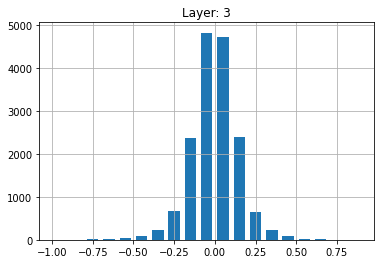

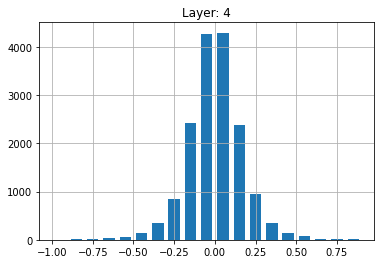

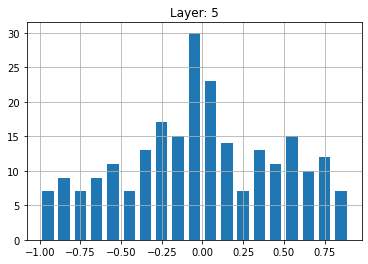

In [65]:
max_ws = np.zeros(len(pinn.Ws))
min_ws = np.zeros(len(pinn.Ws))
for i in range(len(pinn.Ws)):
    max_ws[i] = np.max(pinn.Ws[i].numpy())
    min_ws[i] = np.min(pinn.Ws[i].numpy())
    
index = np.arange(len(pinn.Ws))
bar_width = .35
plt.bar(index , max_ws, bar_width, color='b', alpha = .4)
plt.bar(index + bar_width, min_ws, bar_width, color='r', alpha = .4)

plt.xticks(index + bar_width/2, index)
plt.grid()
plt.show()

for i in range(len(pinn.Ws)):    
    if i == 0:
        bins = np.arange(-1,1,.1)
    elif i >= 1 and i <=4:
        bins = np.arange(-1,1,.1)
    else:
        bins = np.arange(-.5,0.5,.01)
    hists, bins = np.histogram(pinn.Ws[i].numpy(), bins=bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hists, align='center', width=width)
    plt.grid()
    plt.title(f"Layer: {i+1}")
    plt.show()

In [53]:
def plot_output(pinn, T_index = -1, s_factor=2, L=32):
    x_domain = L * np.linspace(0, 1, s_factor*x_size)
    y_domain = L * np.linspace(0, 1, s_factor*y_size)
    N2 = s_factor*x_size * s_factor*y_size

    print(t_star[T_index])
    X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
    XX_test = X_test.flatten()  # N2 x 1
    YY_test = Y_test.flatten()  # N2 x 1
    TT_test = np.repeat(t_star[T_index], N2)  # 1 x N2
    output_test = pinn(np.vstack([XX_test, YY_test, TT_test]).T)
    output_test = np.array(
        [ output_test[:, i].numpy().reshape((s_factor*x_size, s_factor*y_size)) 
         for i in range(output_test.shape[1])])
    
    data_original = data
    _ = plt.figure(figsize=(8,3))
    for i, name in enumerate(["u","v"]):
        plt.subplot(1, 2, i+1)
        plt.title(f"{name}: Observation")
        plt.imshow(data_original[i,:, :, T_index])
        plt.colorbar(shrink=.75)

    plt.show()

    _ = plt.figure(figsize=(8,3))
    for i, name in enumerate(["u","v"]):
        plt.subplot(1, 2, i+1)
        plt.title(f"{name}: Prediction")

        plt.imshow(output_test[i,:, :])
        plt.colorbar(shrink=.75)

    plt.show()

#### Outputs of the TINN

100.0


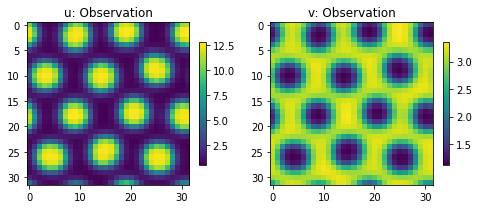

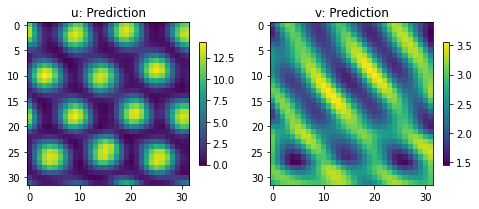

In [66]:
plot_output(pinn, T_index=-1, s_factor=1)

99.6078431372549


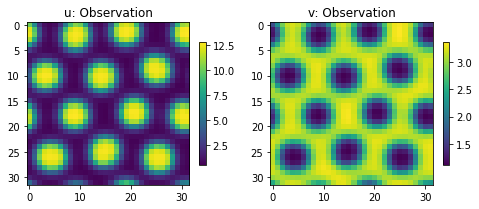

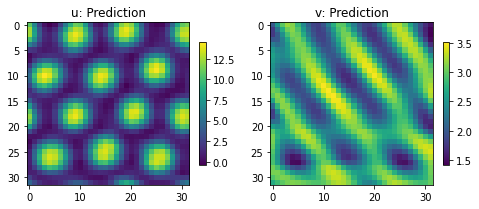

In [67]:
plot_output(pinn, T_index=-2, s_factor=1)

98.82352941176471


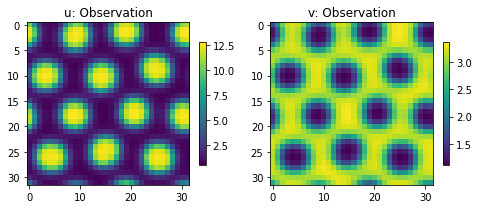

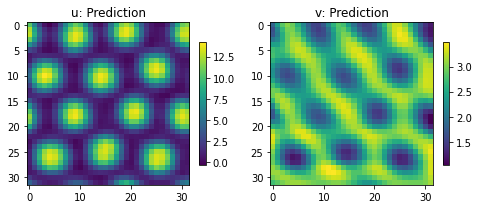

In [68]:
plot_output(pinn, T_index=0, s_factor=1)

In [15]:
s_factor = 1
T_index = -1
x_domain = L * np.linspace(0, 1, s_factor*x_size)
y_domain = L * np.linspace(0, 1, s_factor*y_size)
N2 = s_factor*x_size * s_factor*y_size

print(t_star[T_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(t_star[T_index], N2)  # 1 x N2
output_test = pde_loss.loss(pinn,np.vstack([XX_test, YY_test, TT_test]).T)


95.68627450980392


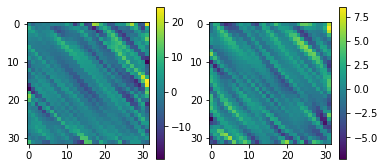

In [16]:
plt.subplot(121)
plt.imshow(output_test[1].numpy().reshape((x_size, y_size)))
plt.colorbar(shrink=.7)
plt.subplot(122)
plt.imshow(output_test[2].numpy().reshape((x_size, y_size)))
plt.colorbar(shrink=.7)
plt.show()

#### Testing the evaluated parameters

In [103]:
from solvers.explicit_Euler import integrate
from solvers.turing_models import Koch_Meinhardt

In [129]:
n = (32, 32)
L = (1.0, 1.0)

Ds = np.array([0.0025, 0.2])
 
sigma_u=0.0000013709
sigma_v=8.3639623771
mu_u=1.1747487351
rho_u=0.1271707249
rho_v=0.1457174021
kappa_u=0.0032018738

f_args = (sigma_u, sigma_v, rho_u, rho_v, kappa_u, mu_u)

with open('../turing_Brusselator.npy', 'rb') as file:
    c0 = np.load(file)[:,:,:, 0]


t = np.linspace(0, 500, 256)

dt = 0.01

sol = integrate(c0, t, dt, n, L, Ds, Koch_Meinhardt, f_args)

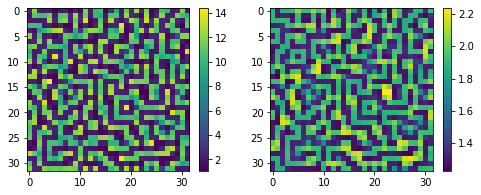

In [130]:

index = -1
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(sol[0,:,:, index])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(sol[1,:,:, index])
plt.colorbar(shrink=.75)
plt.show()

# An example of the spikes for the regularised training

> Here, we can see a spike during the training with the regularizer.
> We must note that the main difference between these spikes and the usual one we see for mini-batch training is that the y do not suddenly return to the previous value but decay exponentially.

> We must remember that the value of $\alpha$ and the moving average introduce some kinds of memory for the system, so the response to sudden change and its decay can affect the moving average. 
> However, compared to the second type of regularisation that uses different hyper-parameters for PDE's coefficients from the NN weights, such spikes have not been observed in the latter case. So, the spikes themselves result from regularisations, and the form of decay (or maybe their growth) results from moving average. 
> When I gradients of PDE's coefficients and NN PDE's gradients, the former is much larger than the latter. Therefore, we sometimes get large changes in the loss for small updates for PDE's coefficients. However, this is not the case for the second regulariser since different hyper-parameters regularised the PDE's gradients, and since the gradient of PDE's gradients was one order of magnitude larger than the NN PDE's gradients, so their hyper-parameters were one order of magnitude smaller, and therefore, changes in PDE's coefficients scaled down by the hyper-parameters and the spikes couldn't happen.
> The drawback was that the second type of regularisation was not successful for mixing models.

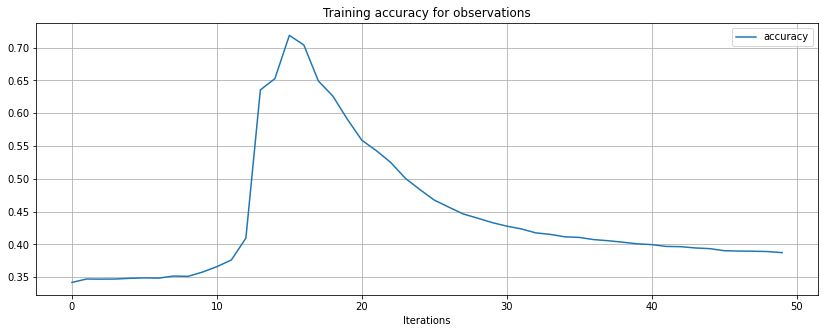

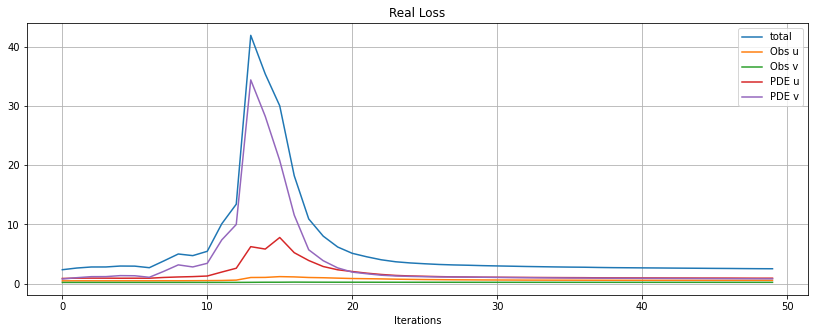

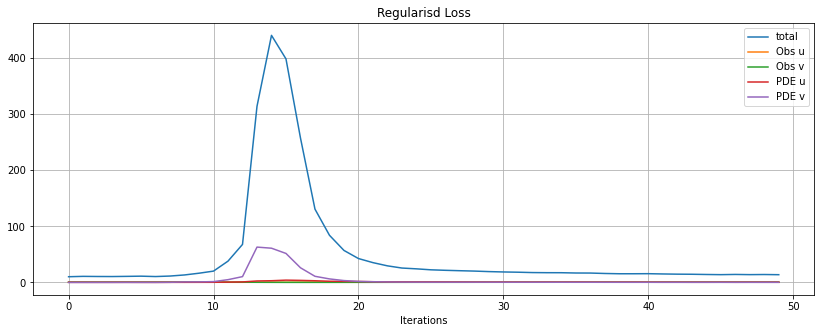

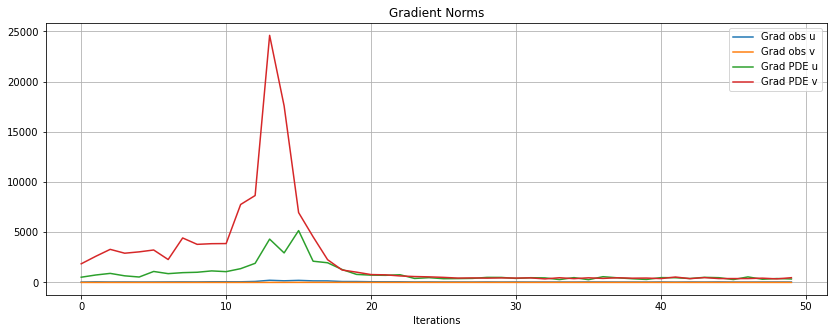

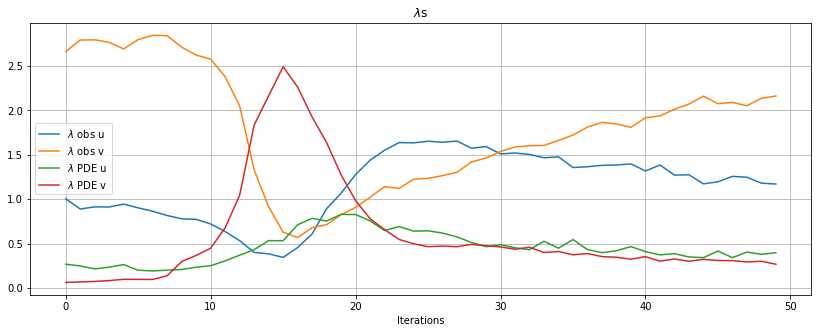

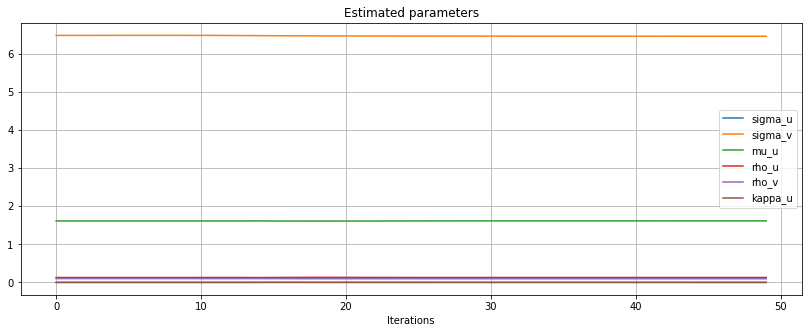

In [60]:
plot_result(merge_dict(results, results2, results3),
            param_names=pde_loss.parameter_names(),  
            start=17360,
            end=17410,
            #end=2000,
            yscale = 'linear')

# Second test

#### Using the ratio for $D_u/D_v$ that makes spots in Koch-Meinhardt model.

In [19]:
data_path = os.path.abspath("../turing_Brusselator.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("../turing_t_Brusselator.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
# Thining the dataset
t_star = t_star[-4:]#t_star[20::32]
data = data[..., -4:]#[..., 20::32]

T = t_star.shape[0]    

# Use the scale and time that is compatible with diffusion coefs
L = 32.0
t_star = t_star*200

x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = dataset['obs_input']
obs_Y = dataset['obs_output']
pde_X = dataset['pde']


In [20]:
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

pinn = tu.NN(layers, lb, ub, dtype=tf.float64)
pde_loss = ASDM(dtype=tf.float64, D_u=0.02, D_v=0.4, init_value=1.0)

In [21]:
model = tu.TINN(pinn, 
                pde_loss, 
                optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
                alpha = 0.5,
                print_precision=".10f")

In [22]:
results = model.train(epochs=50000,
                      batch_size=len(obs_X)//8,
                      X=obs_X,
                      Y=obs_Y,
                      print_interval=200,
                      stop_threshold=1e-5,
                      shuffle=True,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True
                     )


Start of epoch 0
Training observations acc over epoch: 22.0385818481
total loss: 46.0873669944, total regularisd loss (sum of batches): 368.6989359555
obs u loss: 37.0210103254, obs v loss: 7.0561537997
pde u loss: 1.0077863647, pde v loss: 1.0024165047
lambda obs u: 1.0000000000, lambda obs v: 1.0000000000
lambda pde u: 1.0000000000, lambda pde v: 1.0000000000
sigma_u: 0.99920 sigma_v: 0.99920 mu_u: 0.99926 rho_u: 1.00070 
rho_v: 1.00001 kappa_u: 0.99924 
Time taken: 15.18s

Start of epoch 200
Training observations acc over epoch: 8.7014245987
total loss: 18.8667852797, total regularisd loss (sum of batches): 530.4352292033
obs u loss: 16.6353451319, obs v loss: 0.7675041086
pde u loss: 0.7896799304, pde v loss: 0.6742561088
lambda obs u: 3.9856817099, lambda obs v: 0.0075373906
lambda pde u: 0.0031989607, lambda pde v: 0.0035819389
sigma_u: 1.01584 sigma_v: 0.99803 mu_u: 0.93467 rho_u: 1.08900 
rho_v: 0.85142 kappa_u: 0.91442 
Time taken: 39.34s

Start of epoch 400
Training observat


Start of epoch 3400
Training observations acc over epoch: 8.4134721756
total loss: 16.8488797597, total regularisd loss (sum of batches): 510.1183198279
obs u loss: 16.3432719112, obs v loss: 0.4836734167
pde u loss: 0.0203266111, pde v loss: 0.0016078207
lambda obs u: 3.9049472334, lambda obs v: 0.0949010671
lambda pde u: 0.0001408685, lambda pde v: 0.0000108310
sigma_u: 0.27913 sigma_v: 0.95245 mu_u: 0.21309 rho_u: 0.40829 
rho_v: 0.55874 kappa_u: 1.45028 
Time taken: 31.43s

Start of epoch 3600
Training observations acc over epoch: 8.4033441544
total loss: 16.8209576797, total regularisd loss (sum of batches): 510.0748286923
obs u loss: 16.3267751343, obs v loss: 0.4799139692
pde u loss: 0.0129211303, pde v loss: 0.0013474460
lambda obs u: 3.9053720724, lambda obs v: 0.0945397200
lambda pde u: 0.0000813003, lambda pde v: 0.0000069073
sigma_u: 0.20260 sigma_v: 0.93589 mu_u: 0.16189 rho_u: 0.32777 
rho_v: 0.56792 kappa_u: 1.50178 
Time taken: 31.92s

Start of epoch 3800
Training obse


Start of epoch 6800
Training observations acc over epoch: 5.5950398445
total loss: 11.2261948004, total regularisd loss (sum of batches): 339.3426961612
obs u loss: 10.8551234724, obs v loss: 0.3349568563
pde u loss: 0.0024084562, pde v loss: 0.0337060155
lambda obs u: 3.9039938427, lambda obs v: 0.0917812271
lambda pde u: 0.0000354404, lambda pde v: 0.0041894898
sigma_u: 0.00044 sigma_v: 0.00000 mu_u: 0.00000 rho_u: 0.00000 
rho_v: 0.00000 kappa_u: 1.57546 
Time taken: 31.18s

Start of epoch 7000
Training observations acc over epoch: 5.3248414993
total loss: 10.6878647609, total regularisd loss (sum of batches): 322.7273333237
obs u loss: 10.3253996715, obs v loss: 0.3242834223
pde u loss: 0.0024661381, pde v loss: 0.0357155290
lambda obs u: 3.9057294961, lambda obs v: 0.0893429206
lambda pde u: 0.0000422512, lambda pde v: 0.0048853321
sigma_u: 0.00039 sigma_v: 0.00000 mu_u: 0.00000 rho_u: 0.00000 
rho_v: 0.00000 kappa_u: 1.57546 
Time taken: 31.65s

Start of epoch 7200
Training obse


Start of epoch 10400
Training observations acc over epoch: 0.3213563263
total loss: 0.6661025981, total regularisd loss (sum of batches): 17.0646565156
obs u loss: 0.6185306635, obs v loss: 0.0241819659
pde u loss: 0.0026927704, pde v loss: 0.0206971983
lambda obs u: 3.4362374639, lambda obs v: 0.1974383915
lambda pde u: 0.0068350592, lambda pde v: 0.3594890853
sigma_u: 0.00000 sigma_v: 0.06330 mu_u: 0.00000 rho_u: 0.00117 
rho_v: 0.01935 kappa_u: 0.48632 
Time taken: 31.21s

Start of epoch 10600
Training observations acc over epoch: 0.2889797688
total loss: 0.6006906268, total regularisd loss (sum of batches): 15.9060306439
obs u loss: 0.5567625810, obs v loss: 0.0211969284
pde u loss: 0.0026559589, pde v loss: 0.0200751585
lambda obs u: 3.5234943699, lambda obs v: 0.1782036996
lambda pde u: 0.0078150836, lambda pde v: 0.2904868468
sigma_u: 0.00000 sigma_v: 0.08603 mu_u: 0.00000 rho_u: 0.00126 
rho_v: 0.01772 kappa_u: 0.28964 
Time taken: 30.18s

Start of epoch 10800
Training observa


Start of epoch 14000
Training observations acc over epoch: 0.1508394182
total loss: 0.3152963048, total regularisd loss (sum of batches): 8.7804336530
obs u loss: 0.2933547557, obs v loss: 0.0083240927
pde u loss: 0.0015795044, pde v loss: 0.0120379520
lambda obs u: 3.7517030732, lambda obs v: 0.1095421999
lambda pde u: 0.0044366178, lambda pde v: 0.1343181091
sigma_u: 0.00000 sigma_v: 0.11410 mu_u: 0.02538 rho_u: 0.00218 
rho_v: 0.00200 kappa_u: 0.00099 
Time taken: 31.48s

Start of epoch 14200
Training observations acc over epoch: 0.1466923505
total loss: 0.3071313175, total regularisd loss (sum of batches): 8.5776273421
obs u loss: 0.2852759168, obs v loss: 0.0081087901
pde u loss: 0.0016081065, pde v loss: 0.0121385041
lambda obs u: 3.7629493642, lambda obs v: 0.1100891653
lambda pde u: 0.0026196260, lambda pde v: 0.1243418445
sigma_u: 0.00000 sigma_v: 0.11375 mu_u: 0.02552 rho_u: 0.00221 
rho_v: 0.00203 kappa_u: 0.00098 
Time taken: 31.79s

Start of epoch 14400
Training observati


Start of epoch 17600
Training observations acc over epoch: 0.1000646949
total loss: 0.2145169129, total regularisd loss (sum of batches): 5.5923702987
obs u loss: 0.1932711166, obs v loss: 0.0068582522
pde u loss: 0.0016324042, pde v loss: 0.0127551399
lambda obs u: 3.5495752000, lambda obs v: 0.1617728876
lambda pde u: 0.0060187388, lambda pde v: 0.2826331735
sigma_u: 0.00000 sigma_v: 0.11477 mu_u: 0.02915 rho_u: 0.00252 
rho_v: 0.00208 kappa_u: 0.00126 
Time taken: 34.18s

Start of epoch 17800
Training observations acc over epoch: 0.0973039269
total loss: 0.2089193820, total regularisd loss (sum of batches): 5.4133187570
obs u loss: 0.1875467764, obs v loss: 0.0070610918
pde u loss: 0.0016483575, pde v loss: 0.0126631562
lambda obs u: 3.6356116329, lambda obs v: 0.1662137415
lambda pde u: 0.0055216319, lambda pde v: 0.1926529936
sigma_u: 0.00000 sigma_v: 0.11452 mu_u: 0.02944 rho_u: 0.00253 
rho_v: 0.00209 kappa_u: 0.00141 
Time taken: 34.65s

Start of epoch 18000
Training observati


Start of epoch 21200
Training observations acc over epoch: 0.0630525053
total loss: 0.1422165591, total regularisd loss (sum of batches): 3.0528630579
obs u loss: 0.1196184063, obs v loss: 0.0064865959
pde u loss: 0.0018111323, pde v loss: 0.0143004247
lambda obs u: 3.2462530748, lambda obs v: 0.3056337719
lambda pde u: 0.0092216399, lambda pde v: 0.4388915134
sigma_u: 0.00000 sigma_v: 0.11531 mu_u: 0.03267 rho_u: 0.00284 
rho_v: 0.00218 kappa_u: 0.00174 
Time taken: 32.19s

Start of epoch 21400
Training observations acc over epoch: 0.0621386841
total loss: 0.1403895680, total regularisd loss (sum of batches): 2.9640290134
obs u loss: 0.1176453021, obs v loss: 0.0066320692
pde u loss: 0.0018158337, pde v loss: 0.0142963630
lambda obs u: 2.9590459059, lambda obs v: 0.3309335156
lambda pde u: 0.0166252330, lambda pde v: 0.6933953455
sigma_u: 0.00000 sigma_v: 0.11484 mu_u: 0.03290 rho_u: 0.00287 
rho_v: 0.00215 kappa_u: 0.00178 
Time taken: 31.98s

Start of epoch 21600
Training observati


Start of epoch 24800
Training observations acc over epoch: 0.0341699049
total loss: 0.0865357130, total regularisd loss (sum of batches): 1.2421219430
obs u loss: 0.0622011335, obs v loss: 0.0061386833
pde u loss: 0.0019821018, pde v loss: 0.0162137944
lambda obs u: 1.9456166433, lambda obs v: 0.5130413281
lambda pde u: 0.0257620056, lambda pde v: 1.5155800231
sigma_u: 0.00000 sigma_v: 0.11641 mu_u: 0.03776 rho_u: 0.00336 
rho_v: 0.00227 kappa_u: 0.00214 
Time taken: 33.73s

Start of epoch 25000
Training observations acc over epoch: 0.0321252458
total loss: 0.0824797170, total regularisd loss (sum of batches): 1.2802992385
obs u loss: 0.0580753496, obs v loss: 0.0061751396
pde u loss: 0.0019783829, pde v loss: 0.0162508448
lambda obs u: 2.4449048593, lambda obs v: 0.6373458949
lambda pde u: 0.0262010256, lambda pde v: 0.8915482203
sigma_u: 0.00000 sigma_v: 0.11614 mu_u: 0.03803 rho_u: 0.00339 
rho_v: 0.00226 kappa_u: 0.00216 
Time taken: 32.67s

Start of epoch 25200
Training observati


Start of epoch 28400
Training observations acc over epoch: 0.0168035831
total loss: 0.0507577566, total regularisd loss (sum of batches): 0.5429121111
obs u loss: 0.0283166619, obs v loss: 0.0052905025
pde u loss: 0.0019247094, pde v loss: 0.0152258828
lambda obs u: 1.3580421861, lambda obs v: 1.1189297678
lambda pde u: 0.0385776013, lambda pde v: 1.4844504449
sigma_u: 0.00000 sigma_v: 0.11509 mu_u: 0.04149 rho_u: 0.00365 
rho_v: 0.00226 kappa_u: 0.00217 
Time taken: 31.20s

Start of epoch 28600
Training observations acc over epoch: 0.0154016986
total loss: 0.0478805631, total regularisd loss (sum of batches): 0.5431254129
obs u loss: 0.0257158939, obs v loss: 0.0050875055
pde u loss: 0.0018929755, pde v loss: 0.0151841883
lambda obs u: 1.7002832698, lambda obs v: 1.0279026386
lambda pde u: 0.0576605454, lambda pde v: 1.2141535462
sigma_u: 0.00000 sigma_v: 0.11565 mu_u: 0.04164 rho_u: 0.00368 
rho_v: 0.00227 kappa_u: 0.00207 
Time taken: 31.14s

Start of epoch 28800
Training observati


Start of epoch 32000
Training observations acc over epoch: 0.0093675312
total loss: 0.0322136342, total regularisd loss (sum of batches): 0.3094097855
obs u loss: 0.0147914229, obs v loss: 0.0039436394
pde u loss: 0.0017534971, pde v loss: 0.0117250747
lambda obs u: 0.7823927386, lambda obs v: 1.3066661213
lambda pde u: 0.0483915711, lambda pde v: 1.8625495690
sigma_u: 0.00000 sigma_v: 0.11612 mu_u: 0.04329 rho_u: 0.00372 
rho_v: 0.00227 kappa_u: 0.00176 
Time taken: 32.51s

Start of epoch 32200
Training observations acc over epoch: 0.0088404864
total loss: 0.0307994744, total regularisd loss (sum of batches): 0.3095197701
obs u loss: 0.0135916609, obs v loss: 0.0040893130
pde u loss: 0.0017257996, pde v loss: 0.0113927009
lambda obs u: 0.8214399060, lambda obs v: 1.1059590367
lambda pde u: 0.0712436615, lambda pde v: 2.0013573958
sigma_u: 0.00000 sigma_v: 0.11576 mu_u: 0.04339 rho_u: 0.00374 
rho_v: 0.00221 kappa_u: 0.00182 
Time taken: 31.79s

Start of epoch 32400
Training observati


Start of epoch 35600
Training observations acc over epoch: 0.0058228304
total loss: 0.0220016483, total regularisd loss (sum of batches): 0.2160205075
obs u loss: 0.0082817091, obs v loss: 0.0033639520
pde u loss: 0.0016905334, pde v loss: 0.0086654538
lambda obs u: 0.5721656235, lambda obs v: 1.1829990061
lambda pde u: 0.0870792438, lambda pde v: 2.1577561265
sigma_u: 0.00275 sigma_v: 0.11284 mu_u: 0.04572 rho_u: 0.00375 
rho_v: 0.00212 kappa_u: 0.00127 
Time taken: 32.04s

Start of epoch 35800
Training observations acc over epoch: 0.0057013761
total loss: 0.0217676235, total regularisd loss (sum of batches): 0.2062873169
obs u loss: 0.0081845128, obs v loss: 0.0032182397
pde u loss: 0.0017295897, pde v loss: 0.0086352812
lambda obs u: 0.6591725805, lambda obs v: 1.5996773358
lambda pde u: 0.0567441023, lambda pde v: 1.6844059814
sigma_u: 0.00311 sigma_v: 0.11243 mu_u: 0.04592 rho_u: 0.00380 
rho_v: 0.00214 kappa_u: 0.00121 
Time taken: 31.26s

Start of epoch 36000
Training observati


Start of epoch 39200
Training observations acc over epoch: 0.0041424753
total loss: 0.0172935259, total regularisd loss (sum of batches): 0.1781714746
obs u loss: 0.0055831687, obs v loss: 0.0027017816
pde u loss: 0.0016784761, pde v loss: 0.0073300995
lambda obs u: 0.3914221482, lambda obs v: 1.3442693910
lambda pde u: 0.0798865714, lambda pde v: 2.1844218894
sigma_u: 0.00768 sigma_v: 0.11307 mu_u: 0.04947 rho_u: 0.00382 
rho_v: 0.00206 kappa_u: 0.00088 
Time taken: 32.19s

Start of epoch 39400
Training observations acc over epoch: 0.0040667923
total loss: 0.0169089561, total regularisd loss (sum of batches): 0.1714065281
obs u loss: 0.0052212723, obs v loss: 0.0029123136
pde u loss: 0.0016743843, pde v loss: 0.0071009859
lambda obs u: 0.5062906639, lambda obs v: 1.3847333845
lambda pde u: 0.0917037970, lambda pde v: 2.0172721545
sigma_u: 0.00797 sigma_v: 0.11332 mu_u: 0.04965 rho_u: 0.00386 
rho_v: 0.00207 kappa_u: 0.00087 
Time taken: 32.81s

Start of epoch 39600
Training observati


Start of epoch 42800
Training observations acc over epoch: 0.0033632712
total loss: 0.0146677508, total regularisd loss (sum of batches): 0.1450317305
obs u loss: 0.0042102593, obs v loss: 0.0025162827
pde u loss: 0.0016465603, pde v loss: 0.0062946485
lambda obs u: 0.3757199398, lambda obs v: 1.2933164019
lambda pde u: 0.1810220482, lambda pde v: 2.1499416101
sigma_u: 0.00987 sigma_v: 0.11509 mu_u: 0.05187 rho_u: 0.00392 
rho_v: 0.00203 kappa_u: 0.00069 
Time taken: 31.04s

Start of epoch 43000
Training observations acc over epoch: 0.0034850324
total loss: 0.0148375931, total regularisd loss (sum of batches): 0.1524733489
obs u loss: 0.0044599909, obs v loss: 0.0025100737
pde u loss: 0.0016434257, pde v loss: 0.0062241029
lambda obs u: 0.3167443333, lambda obs v: 1.4909420300
lambda pde u: 0.1693230748, lambda pde v: 2.0229905619
sigma_u: 0.00990 sigma_v: 0.11503 mu_u: 0.05199 rho_u: 0.00393 
rho_v: 0.00205 kappa_u: 0.00068 
Time taken: 30.77s

Start of epoch 43200
Training observati


Start of epoch 46400
Training observations acc over epoch: 0.0029902710
total loss: 0.0130522766, total regularisd loss (sum of batches): 0.1245784143
obs u loss: 0.0036177983, obs v loss: 0.0023627426
pde u loss: 0.0016646337, pde v loss: 0.0054071021
lambda obs u: 0.3337390917, lambda obs v: 1.6053365134
lambda pde u: 0.0951609002, lambda pde v: 1.9657634947
sigma_u: 0.01074 sigma_v: 0.11584 mu_u: 0.05341 rho_u: 0.00398 
rho_v: 0.00205 kappa_u: 0.00064 
Time taken: 31.56s

Start of epoch 46600
Training observations acc over epoch: 0.0027543693
total loss: 0.0125985226, total regularisd loss (sum of batches): 0.1227196835
obs u loss: 0.0032525302, obs v loss: 0.0022562078
pde u loss: 0.0016434839, pde v loss: 0.0054463007
lambda obs u: 0.3169668847, lambda obs v: 1.3705755736
lambda pde u: 0.1851823161, lambda pde v: 2.1272752256
sigma_u: 0.01066 sigma_v: 0.11641 mu_u: 0.05336 rho_u: 0.00402 
rho_v: 0.00206 kappa_u: 0.00063 
Time taken: 32.30s

Start of epoch 46800
Training observati

In [24]:
pde_loss.print_precision=".10f"
print(pde_loss.trainables_str())

sigma_u: 0.0105424539 sigma_v: 0.1179830753 mu_u: 0.0535223515 rho_u: 0.0040499509 
rho_v: 0.0020518891 kappa_u: 0.0006478623 


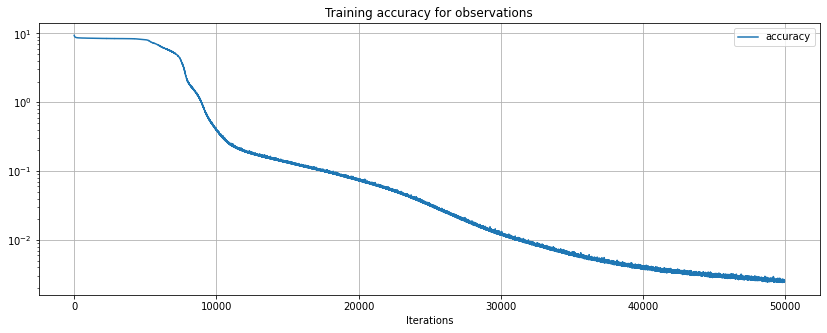

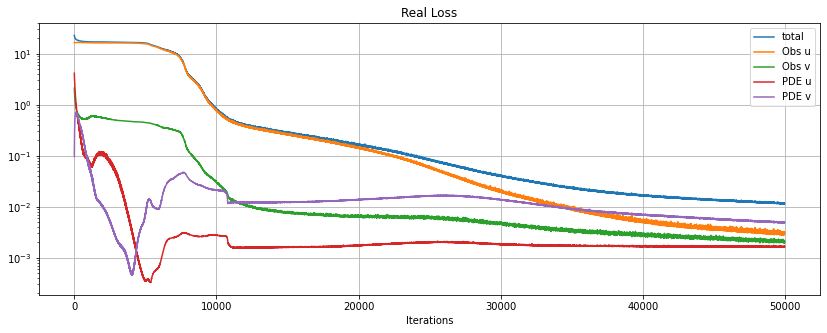

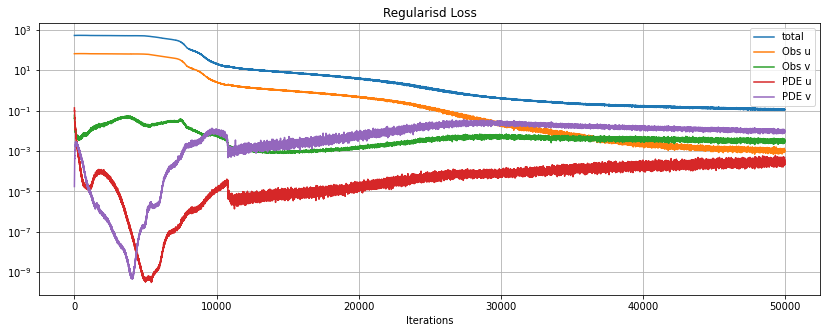

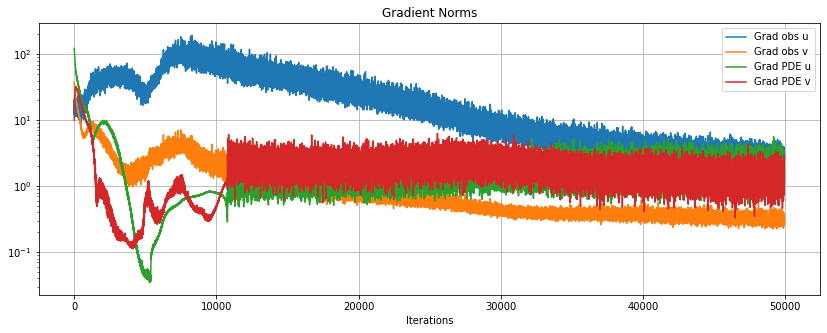

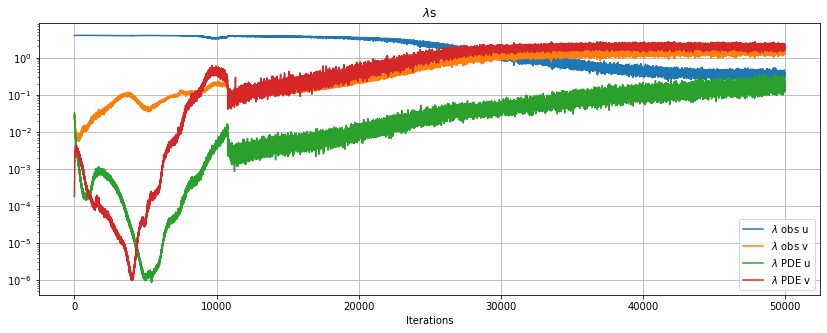

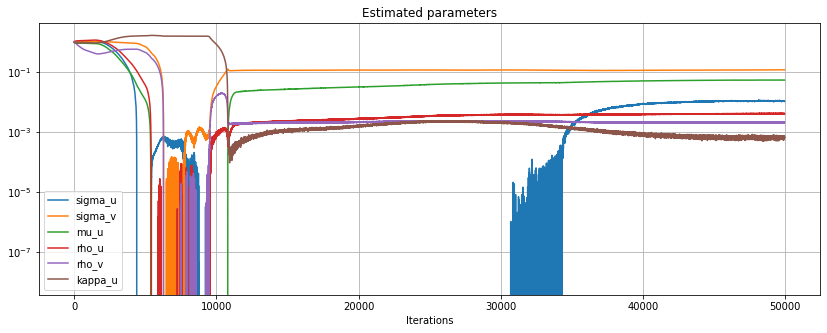

In [26]:
plot_result(results,
            param_names=pde_loss.parameter_names(),  
            start=40,
            yscale = 'log')

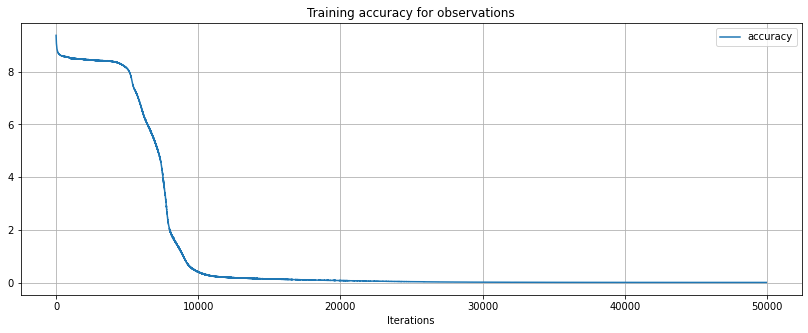

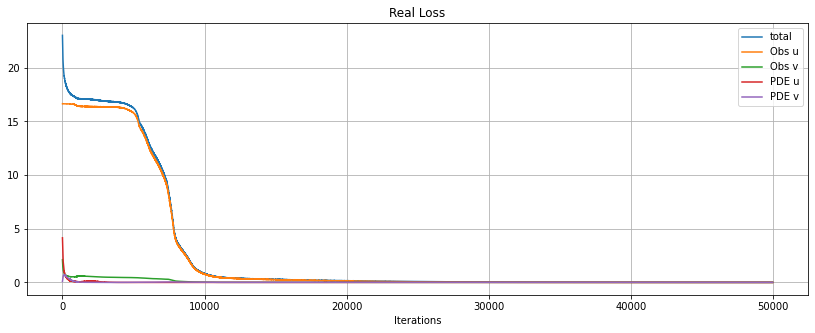

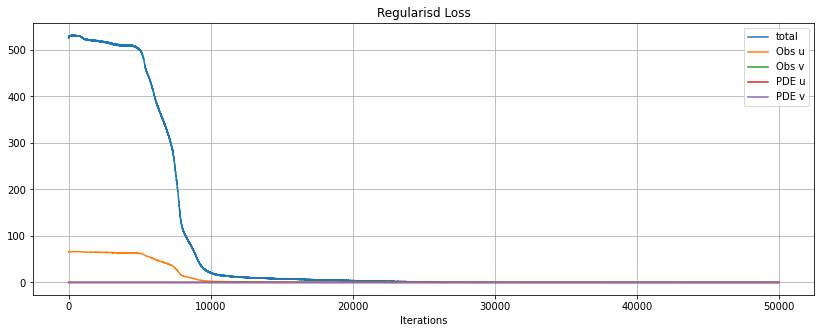

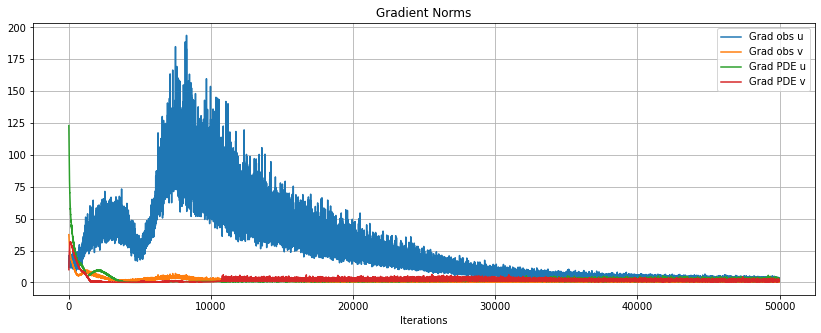

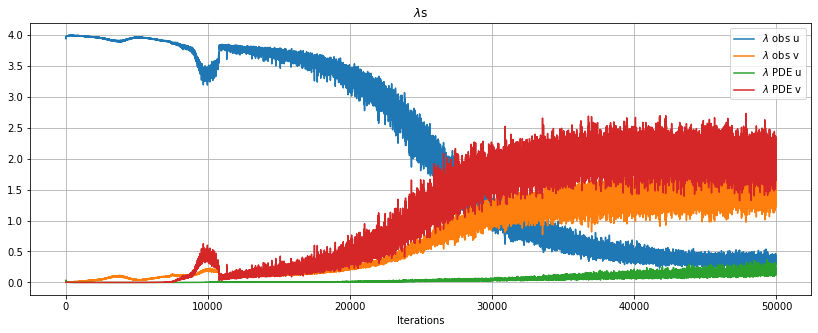

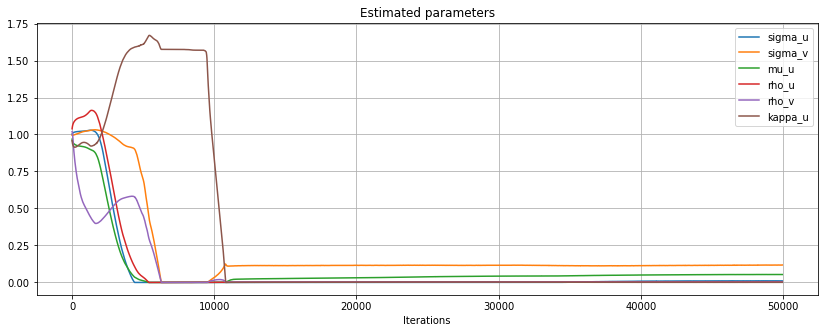

In [27]:
plot_result(results,
            param_names=pde_loss.parameter_names(),  
            start=40,
            yscale = 'linear')

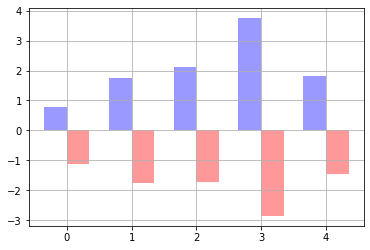

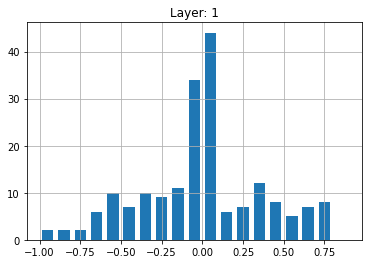

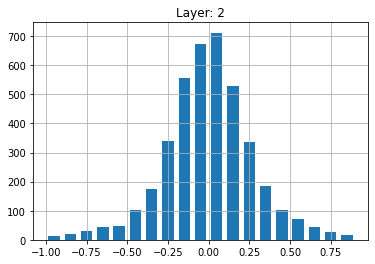

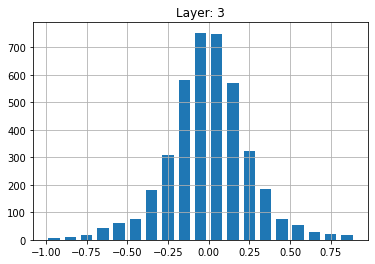

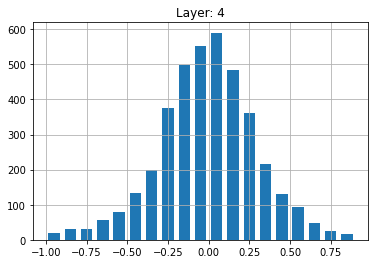

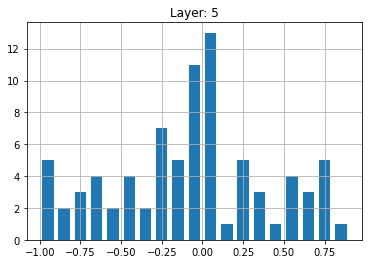

In [28]:
max_ws = np.zeros(len(pinn.Ws))
min_ws = np.zeros(len(pinn.Ws))
for i in range(len(pinn.Ws)):
    max_ws[i] = np.max(pinn.Ws[i].numpy())
    min_ws[i] = np.min(pinn.Ws[i].numpy())
    
index = np.arange(len(pinn.Ws))
bar_width = .35
plt.bar(index , max_ws, bar_width, color='b', alpha = .4)
plt.bar(index + bar_width, min_ws, bar_width, color='r', alpha = .4)

plt.xticks(index + bar_width/2, index)
plt.grid()
plt.show()

for i in range(len(pinn.Ws)):    
    if i == 0:
        bins = np.arange(-1,1,.1)
    elif i >= 1 and i <=4:
        bins = np.arange(-1,1,.1)
    else:
        bins = np.arange(-.5,0.5,.01)
    hists, bins = np.histogram(pinn.Ws[i].numpy(), bins=bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hists, align='center', width=width)
    plt.grid()
    plt.title(f"Layer: {i+1}")
    plt.show()

#### Outputs of the trained TINN

20000.0


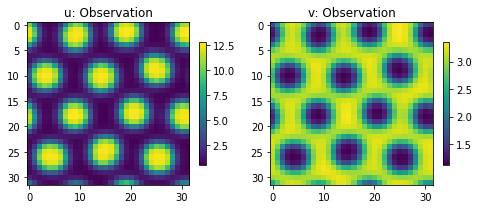

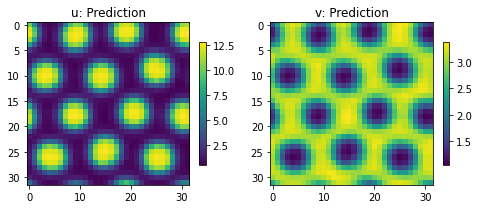

In [29]:
plot_output(pinn, T_index=-1, s_factor=1)

#### Testing the evaluated parameters

In [133]:
from solvers.explicit_Euler import integrate
from solvers.turing_models import Koch_Meinhardt

In [152]:
n = (32, 32)
L = (32.0, 32.0)

Ds = np.array([0.02, 0.4])

        
sigma_u=0.0105424539
sigma_v=0.1179830753
mu_u=0.0535223515
rho_u=0.0040499509
rho_v=0.0020518891
kappa_u=0.0006478623 

f_args = (sigma_u, sigma_v, rho_u, rho_v, kappa_u, mu_u)

with open('../turing_Brusselator.npy', 'rb') as file:
    c0 = np.load(file)[:,:,:, 0]

t = np.linspace(0, 4000, 256)

dt = 0.1

sol = integrate(c0, t, dt, n, L, Ds, Koch_Meinhardt, f_args)

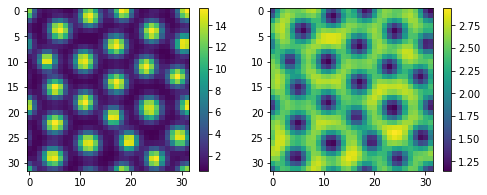

In [153]:
index = -1
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(sol[0,:,:, index])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(sol[1,:,:, index])
plt.colorbar(shrink=.75)
plt.show()

# Third example: All parameters are unknown

In [84]:
data_path = os.path.abspath("../turing_Brusselator.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("../turing_t_Brusselator.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
# Thining the dataset
t_star = t_star[-4:]#t_star[20::32]
data = data[..., -4:]#[..., 20::32]

T = t_star.shape[0]    

# Use the scale and time that is compatible with diffusion coefs
L = 32.0
t_star = t_star*200

x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

dataset2 = create_dataset(data, t_star, N, T, L, **model_params)
lb2 = dataset2['lb']
ub2 = dataset2['ub']
obs_X2 = dataset2['obs_input']
obs_Y2 = dataset2['obs_output']

In [90]:
layers = [3, 64, 64, 64, 64, 2]

pinn2 = tu.NN(layers, lb2, ub2, dtype=tf.float64)
pde_loss2 = ASDM(dtype=tf.float64, init_value=1.0)
pde_non_zero = Non_zero_params("ASDM", 
                               parameters=[pde_loss2.D_u, pde_loss2.D_v,
                                           pde_loss2.rho_u, pde_loss2.rho_v, pde_loss2.mu_u], 
                               epsilon=1e-4,
                               print_precision=".10f")

In [91]:
model2 = tu.TINN(pinn2,                 
                pde_loss2, 
                extra_loss=[pde_non_zero], 
                optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
                alpha = 0.5,
                print_precision=".10f")

In [92]:
results2 = model2.train(epochs=50000,
                      batch_size=len(obs_X2)//8,
                      X=obs_X2,
                      Y=obs_Y2,
                      print_interval=200,
                      stop_threshold=1e-5,
                      shuffle=True,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True
                     )


Start of epoch 0
Training observations acc over epoch: 15.9894018173
total loss: 45.9557183001, total regularisd loss (sum of batches): 367.6457464004
obs u loss: 36.9408346870, obs v loss: 7.0292256763
pde u loss: 0.9875441239, pde v loss: 0.9976139176
lambda obs u: 1.0000000000, lambda obs v: 1.0000000000
lambda pde u: 1.0000000000, lambda pde v: 1.0000000000
D_u: 1.00079 D_v: 1.00077 sigma_u: 0.99920 sigma_v: 0.99920 
mu_u: 0.99971 rho_u: 1.00043 rho_v: 1.00076 kappa_u: 0.99949 

extra loss non_zero_ASDM: 0.0004998954
Time taken: 14.62s

Start of epoch 200
Training observations acc over epoch: 8.6584024429
total loss: 18.7230598282, total regularisd loss (sum of batches): 530.6359431131
obs u loss: 16.6304353355, obs v loss: 0.6863703756
pde u loss: 0.6404147674, pde v loss: 0.7653432087
lambda obs u: 3.9862238638, lambda obs v: 0.0070230672
lambda pde u: 0.0025102882, lambda pde v: 0.0042427808
D_u: 1.10009 D_v: 1.14601 sigma_u: 1.00693 sigma_v: 1.00051 
mu_u: 0.93334 rho_u: 1.088


Start of epoch 3000
Training observations acc over epoch: 8.2034626007
total loss: 16.6736702148, total regularisd loss (sum of batches): 503.4815235091
obs u loss: 15.9152860287, obs v loss: 0.4916391725
pde u loss: 0.1959575532, pde v loss: 0.0698273354
lambda obs u: 3.9554334559, lambda obs v: 0.0390649601
lambda pde u: 0.0047456276, lambda pde v: 0.0007559563
D_u: 0.58357 D_v: 2.56568 sigma_u: 0.17407 sigma_v: 1.73700 
mu_u: 0.19825 rho_u: 0.57838 rho_v: 1.38012 kappa_u: 1.95426 

extra loss non_zero_ASDM: 0.0009601249
Time taken: 38.27s

Start of epoch 3200
Training observations acc over epoch: 8.1868915558
total loss: 16.6073646763, total regularisd loss (sum of batches): 502.2753375175
obs u loss: 15.8888511925, obs v loss: 0.4849304999
pde u loss: 0.1608104345, pde v loss: 0.0717991209
lambda obs u: 3.9472983544, lambda obs v: 0.0470551375
lambda pde u: 0.0046174697, lambda pde v: 0.0010290384
D_u: 0.45024 D_v: 2.37781 sigma_u: 0.14026 sigma_v: 1.78737 
mu_u: 0.20553 rho_u: 0.


Start of epoch 6000
Training observations acc over epoch: 2.0689222813
total loss: 4.2470637147, total regularisd loss (sum of batches): 123.9669204981
obs u loss: 4.0208861519, obs v loss: 0.1169586227
pde u loss: 0.0819073048, pde v loss: 0.0223319820
lambda obs u: 3.8538167696, lambda obs v: 0.1016027503
lambda pde u: 0.0282307379, lambda pde v: 0.0163497422
D_u: 0.05510 D_v: 0.25617 sigma_u: 0.02487 sigma_v: 0.29089 
mu_u: 0.04482 rho_u: 0.29234 rho_v: 0.46957 kappa_u: 3.59502 

extra loss non_zero_ASDM: 0.0049796532
Time taken: 35.66s

Start of epoch 6200
Training observations acc over epoch: 1.8744963408
total loss: 3.8541796266, total regularisd loss (sum of batches): 112.3815155983
obs u loss: 3.6450788746, obs v loss: 0.1039140556
pde u loss: 0.0793005128, pde v loss: 0.0207340274
lambda obs u: 3.8464503140, lambda obs v: 0.1022346264
lambda pde u: 0.0325369468, lambda pde v: 0.0187781127
D_u: 0.05329 D_v: 0.24940 sigma_u: 0.02785 sigma_v: 0.26053 
mu_u: 0.04334 rho_u: 0.2914


Start of epoch 9000
Training observations acc over epoch: 0.3225819170
total loss: 0.6923293958, total regularisd loss (sum of batches): 18.4222118642
obs u loss: 0.6241874779, obs v loss: 0.0209763559
pde u loss: 0.0319234396, pde v loss: 0.0065191320
lambda obs u: 3.6591700252, lambda obs v: 0.1211079411
lambda pde u: 0.1408314858, lambda pde v: 0.0788905478
D_u: 0.03159 D_v: 0.14306 sigma_u: 0.03564 sigma_v: 0.11411 
mu_u: 0.02476 rho_u: 0.19149 rho_v: 0.30336 kappa_u: 5.83180 

extra loss non_zero_ASDM: 0.0087229903
Time taken: 34.10s

Start of epoch 9200
Training observations acc over epoch: 0.2923352718
total loss: 0.6264567232, total regularisd loss (sum of batches): 16.6624339095
obs u loss: 0.5665183967, obs v loss: 0.0181521635
pde u loss: 0.0267687099, pde v loss: 0.0054687530
lambda obs u: 3.6625767641, lambda obs v: 0.1208969092
lambda pde u: 0.1323261752, lambda pde v: 0.0842001514
D_u: 0.02899 D_v: 0.12875 sigma_u: 0.03324 sigma_v: 0.10512 
mu_u: 0.02293 rho_u: 0.18002 


Start of epoch 12000
Training observations acc over epoch: 0.1447500288
total loss: 0.3253491007, total regularisd loss (sum of batches): 8.0785596487
obs u loss: 0.2822465925, obs v loss: 0.0072534495
pde u loss: 0.0203440836, pde v loss: 0.0044157848
lambda obs u: 3.4899719211, lambda obs v: 0.0815866376
lambda pde u: 0.2701932340, lambda pde v: 0.1582482073
D_u: 0.02393 D_v: 0.11374 sigma_u: 0.03915 sigma_v: 0.08480 
mu_u: 0.01932 rho_u: 0.17231 rho_v: 0.30141 kappa_u: 8.08120 

extra loss non_zero_ASDM: 0.0110891903
Time taken: 37.80s

Start of epoch 12200
Training observations acc over epoch: 0.1433527768
total loss: 0.3216443783, total regularisd loss (sum of batches): 7.9834038137
obs u loss: 0.2795164826, obs v loss: 0.0071890906
pde u loss: 0.0196246498, pde v loss: 0.0039734730
lambda obs u: 3.4939961260, lambda obs v: 0.0807284517
lambda pde u: 0.2609607195, lambda pde v: 0.1643147027
D_u: 0.02365 D_v: 0.10733 sigma_u: 0.03658 sigma_v: 0.08228 
mu_u: 0.01957 rho_u: 0.16701 


Start of epoch 15200
Training observations acc over epoch: 0.1001872346
total loss: 0.2353579527, total regularisd loss (sum of batches): 5.6407494058
obs u loss: 0.1955937135, obs v loss: 0.0047807734
pde u loss: 0.0201521177, pde v loss: 0.0035113021
lambda obs u: 3.4275766513, lambda obs v: 0.0723086248
lambda pde u: 0.3218759603, lambda pde v: 0.1782387636
D_u: 0.02356 D_v: 0.10167 sigma_u: 0.04245 sigma_v: 0.07024 
mu_u: 0.01922 rho_u: 0.17095 rho_v: 0.31541 kappa_u: 10.49714 

extra loss non_zero_ASDM: 0.0113200459
Time taken: 35.82s

Start of epoch 15400
Training observations acc over epoch: 0.0966032445
total loss: 0.2239191995, total regularisd loss (sum of batches): 5.1669570322
obs u loss: 0.1884584119, obs v loss: 0.0047480588
pde u loss: 0.0145998748, pde v loss: 0.0029292203
lambda obs u: 3.4503094065, lambda obs v: 0.0722567665
lambda pde u: 0.2806493762, lambda pde v: 0.1967844508
D_u: 0.01992 D_v: 0.09065 sigma_u: 0.03950 sigma_v: 0.06881 
mu_u: 0.01663 rho_u: 0.16415


Start of epoch 18200
Training observations acc over epoch: 0.0675044060
total loss: 0.1658060196, total regularisd loss (sum of batches): 3.6401594385
obs u loss: 0.1315519299, obs v loss: 0.0034568876
pde u loss: 0.0149916001, pde v loss: 0.0026007574
lambda obs u: 3.4000387321, lambda obs v: 0.0768329634
lambda pde u: 0.3136560181, lambda pde v: 0.2094722864
D_u: 0.01994 D_v: 0.08470 sigma_u: 0.04044 sigma_v: 0.06023 
mu_u: 0.01698 rho_u: 0.16304 rho_v: 0.31631 kappa_u: 12.79432 

extra loss non_zero_ASDM: 0.0132048446
Time taken: 35.55s

Start of epoch 18400
Training observations acc over epoch: 0.0651306212
total loss: 0.1623446270, total regularisd loss (sum of batches): 3.5479702207
obs u loss: 0.1270135436, obs v loss: 0.0032477063
pde u loss: 0.0167738053, pde v loss: 0.0027466826
lambda obs u: 3.3649864971, lambda obs v: 0.0808718287
lambda pde u: 0.3519205340, lambda pde v: 0.2022211402
D_u: 0.02095 D_v: 0.08778 sigma_u: 0.04157 sigma_v: 0.05905 
mu_u: 0.01733 rho_u: 0.16391


Start of epoch 21200
Training observations acc over epoch: 0.0386070199
total loss: 0.1067500067, total regularisd loss (sum of batches): 1.9764351235
obs u loss: 0.0748333711, obs v loss: 0.0023806717
pde u loss: 0.0126275200, pde v loss: 0.0021450411
lambda obs u: 3.1191862298, lambda obs v: 0.0945779910
lambda pde u: 0.4749540033, lambda pde v: 0.3112817759
D_u: 0.01740 D_v: 0.07251 sigma_u: 0.03991 sigma_v: 0.04950 
mu_u: 0.01507 rho_u: 0.15248 rho_v: 0.30216 kappa_u: 15.11096 

extra loss non_zero_ASDM: 0.0147634029
Time taken: 36.38s

Start of epoch 21400
Training observations acc over epoch: 0.0376341306
total loss: 0.1052296889, total regularisd loss (sum of batches): 1.8998936698
obs u loss: 0.0729751025, obs v loss: 0.0022931553
pde u loss: 0.0131267793, pde v loss: 0.0023856331
lambda obs u: 2.8807960625, lambda obs v: 0.0955721030
lambda pde u: 0.6140498726, lambda pde v: 0.4095819619
D_u: 0.01728 D_v: 0.07645 sigma_u: 0.04214 sigma_v: 0.04997 
mu_u: 0.01515 rho_u: 0.15716


Start of epoch 24200
Training observations acc over epoch: 0.0205489658
total loss: 0.0699280839, total regularisd loss (sum of batches): 1.0234881529
obs u loss: 0.0394821567, obs v loss: 0.0016157777
pde u loss: 0.0103013351, pde v loss: 0.0018962520
lambda obs u: 2.6945576245, lambda obs v: 0.1285531178
lambda pde u: 0.6991237627, lambda pde v: 0.4777654950
D_u: 0.01496 D_v: 0.06454 sigma_u: 0.03919 sigma_v: 0.04169 
mu_u: 0.01356 rho_u: 0.14622 rho_v: 0.29062 kappa_u: 17.44100 

extra loss non_zero_ASDM: 0.0166325625
Time taken: 36.33s

Start of epoch 24400
Training observations acc over epoch: 0.0204517767
total loss: 0.0695156597, total regularisd loss (sum of batches): 0.9799202427
obs u loss: 0.0392770403, obs v loss: 0.0016265152
pde u loss: 0.0095237098, pde v loss: 0.0018032615
lambda obs u: 2.4121824007, lambda obs v: 0.1286272600
lambda pde u: 0.8692224871, lambda pde v: 0.5899678523
D_u: 0.01403 D_v: 0.06262 sigma_u: 0.03824 sigma_v: 0.04075 
mu_u: 0.01277 rho_u: 0.14299


Start of epoch 27200
Training observations acc over epoch: 0.0110327266
total loss: 0.0506106871, total regularisd loss (sum of batches): 0.5773649849
obs u loss: 0.0208347847, obs v loss: 0.0012306692
pde u loss: 0.0081355283, pde v loss: 0.0014540096
lambda obs u: 2.1067131423, lambda obs v: 0.2012605296
lambda pde u: 1.0238212304, lambda pde v: 0.6682050977
D_u: 0.01297 D_v: 0.05464 sigma_u: 0.03524 sigma_v: 0.03511 
mu_u: 0.01193 rho_u: 0.13500 rho_v: 0.27535 kappa_u: 19.78277 

extra loss non_zero_ASDM: 0.0189556953
Time taken: 38.59s

Start of epoch 27400
Training observations acc over epoch: 0.0108516738
total loss: 0.0503211569, total regularisd loss (sum of batches): 0.5370597113
obs u loss: 0.0204909935, obs v loss: 0.0012123523
pde u loss: 0.0076079283, pde v loss: 0.0015009331
lambda obs u: 1.8717322444, lambda obs v: 0.1915659906
lambda pde u: 1.1381963294, lambda pde v: 0.7985054356
D_u: 0.01226 D_v: 0.05505 sigma_u: 0.03578 sigma_v: 0.03497 
mu_u: 0.01150 rho_u: 0.13609


Start of epoch 30200
Training observations acc over epoch: 0.0057644974
total loss: 0.0405310476, total regularisd loss (sum of batches): 0.3530169052
obs u loss: 0.0105613024, obs v loss: 0.0009676925
pde u loss: 0.0062079892, pde v loss: 0.0011930932
lambda obs u: 1.0751586098, lambda obs v: 0.2649464330
lambda pde u: 1.5665578618, lambda pde v: 1.0933370954
D_u: 0.01122 D_v: 0.04849 sigma_u: 0.03317 sigma_v: 0.02993 
mu_u: 0.01053 rho_u: 0.12793 rho_v: 0.26241 kappa_u: 22.13232 

extra loss non_zero_ASDM: 0.0216009703
Time taken: 35.02s

Start of epoch 30400
Training observations acc over epoch: 0.0054146517
total loss: 0.0397126971, total regularisd loss (sum of batches): 0.3573134693
obs u loss: 0.0098935066, obs v loss: 0.0009357960
pde u loss: 0.0064675296, pde v loss: 0.0012826693
lambda obs u: 1.1745376433, lambda obs v: 0.2676046403
lambda pde u: 1.5213584696, lambda pde v: 1.0364992468
D_u: 0.01118 D_v: 0.05101 sigma_u: 0.03404 sigma_v: 0.02969 
mu_u: 0.01057 rho_u: 0.13000


Start of epoch 33200
Training observations acc over epoch: 0.0030549206
total loss: 0.0350739131, total regularisd loss (sum of batches): 0.3026401875
obs u loss: 0.0053169457, obs v loss: 0.0007928958
pde u loss: 0.0059151775, pde v loss: 0.0010855827
lambda obs u: 0.7311405092, lambda obs v: 0.3671612323
lambda pde u: 1.7476699688, lambda pde v: 1.1540282897
D_u: 0.01104 D_v: 0.04762 sigma_u: 0.03256 sigma_v: 0.02651 
mu_u: 0.01020 rho_u: 0.12674 rho_v: 0.25989 kappa_u: 24.48437 

extra loss non_zero_ASDM: 0.0219633114
Time taken: 34.85s

Start of epoch 33400
Training observations acc over epoch: 0.0030716190
total loss: 0.0354109336, total regularisd loss (sum of batches): 0.3014465920
obs u loss: 0.0053527720, obs v loss: 0.0007904644
pde u loss: 0.0054712920, pde v loss: 0.0010605708
lambda obs u: 0.6690876264, lambda obs v: 0.3410311861
lambda pde u: 1.7683046271, lambda pde v: 1.2215765603
D_u: 0.01084 D_v: 0.04686 sigma_u: 0.03258 sigma_v: 0.02630 
mu_u: 0.00997 rho_u: 0.12662


Start of epoch 36200
Training observations acc over epoch: 0.0022897995
total loss: 0.0334995430, total regularisd loss (sum of batches): 0.2892418380
obs u loss: 0.0038876258, obs v loss: 0.0006919728
pde u loss: 0.0055255479, pde v loss: 0.0010050960
lambda obs u: 0.4988488187, lambda obs v: 0.3797372315
lambda pde u: 1.8744458436, lambda pde v: 1.2469681062
D_u: 0.01091 D_v: 0.04697 sigma_u: 0.03265 sigma_v: 0.02468 
mu_u: 0.01001 rho_u: 0.12921 rho_v: 0.26559 kappa_u: 26.83451 

extra loss non_zero_ASDM: 0.0223893005
Time taken: 34.96s

Start of epoch 36400
Training observations acc over epoch: 0.0021521749
total loss: 0.0333884241, total regularisd loss (sum of batches): 0.2884970525
obs u loss: 0.0036067726, obs v loss: 0.0006975772
pde u loss: 0.0053058925, pde v loss: 0.0009739810
lambda obs u: 0.4862318420, lambda obs v: 0.3576783238
lambda pde u: 1.8933084096, lambda pde v: 1.2627814246
D_u: 0.01082 D_v: 0.04632 sigma_u: 0.03251 sigma_v: 0.02465 
mu_u: 0.00987 rho_u: 0.12908


Start of epoch 39200
Training observations acc over epoch: 0.0018662390
total loss: 0.0326661351, total regularisd loss (sum of batches): 0.2845707880
obs u loss: 0.0030821822, obs v loss: 0.0006502954
pde u loss: 0.0051417643, pde v loss: 0.0009457283
lambda obs u: 0.3732472652, lambda obs v: 0.3393603428
lambda pde u: 1.9716178936, lambda pde v: 1.3157744984
D_u: 0.01073 D_v: 0.04681 sigma_u: 0.03278 sigma_v: 0.02359 
mu_u: 0.00976 rho_u: 0.13287 rho_v: 0.27603 kappa_u: 29.18426 

extra loss non_zero_ASDM: 0.0228461649
Time taken: 35.33s

Start of epoch 39400
Training observations acc over epoch: 0.0019862747
total loss: 0.0327201701, total regularisd loss (sum of batches): 0.2851904824
obs u loss: 0.0033342769, obs v loss: 0.0006382717
pde u loss: 0.0053241302, pde v loss: 0.0009704447
lambda obs u: 0.3733495889, lambda obs v: 0.3612657560
lambda pde u: 1.9594678522, lambda pde v: 1.3059168029
D_u: 0.01088 D_v: 0.04750 sigma_u: 0.03293 sigma_v: 0.02351 
mu_u: 0.00987 rho_u: 0.13352


Start of epoch 42200
Training observations acc over epoch: 0.0016843713
total loss: 0.0321307249, total regularisd loss (sum of batches): 0.2809800970
obs u loss: 0.0027628948, obs v loss: 0.0006058481
pde u loss: 0.0049873330, pde v loss: 0.0009219824
lambda obs u: 0.3244804727, lambda obs v: 0.3665062551
lambda pde u: 1.9764529522, lambda pde v: 1.3325603200
D_u: 0.01087 D_v: 0.04727 sigma_u: 0.03317 sigma_v: 0.02279 
mu_u: 0.00971 rho_u: 0.13763 rho_v: 0.28836 kappa_u: 31.53336 

extra loss non_zero_ASDM: 0.0228526666
Time taken: 34.14s

Start of epoch 42400
Training observations acc over epoch: 0.0017177257
total loss: 0.0320053772, total regularisd loss (sum of batches): 0.2801660748
obs u loss: 0.0028283926, obs v loss: 0.0006070577
pde u loss: 0.0051671216, pde v loss: 0.0009233817
lambda obs u: 0.3007994524, lambda obs v: 0.3434191017
lambda pde u: 2.0173152523, lambda pde v: 1.3384661937
D_u: 0.01097 D_v: 0.04736 sigma_u: 0.03319 sigma_v: 0.02284 
mu_u: 0.00988 rho_u: 0.13807


Start of epoch 45200
Training observations acc over epoch: 0.0015565058
total loss: 0.0315734714, total regularisd loss (sum of batches): 0.2775894538
obs u loss: 0.0025356031, obs v loss: 0.0005774086
pde u loss: 0.0049663320, pde v loss: 0.0009072811
lambda obs u: 0.3170671951, lambda obs v: 0.3650991625
lambda pde u: 1.9871713518, lambda pde v: 1.3306622907
D_u: 0.01087 D_v: 0.04786 sigma_u: 0.03364 sigma_v: 0.02215 
mu_u: 0.00974 rho_u: 0.14277 rho_v: 0.30156 kappa_u: 33.88248 

extra loss non_zero_ASDM: 0.0225868466
Time taken: 35.68s

Start of epoch 45400
Training observations acc over epoch: 0.0015013490
total loss: 0.0314464676, total regularisd loss (sum of batches): 0.2774320336
obs u loss: 0.0024252293, obs v loss: 0.0005774689
pde u loss: 0.0049544109, pde v loss: 0.0008967095
lambda obs u: 0.3405606156, lambda obs v: 0.3731828958
lambda pde u: 1.9726211401, lambda pde v: 1.3136353485
D_u: 0.01093 D_v: 0.04775 sigma_u: 0.03351 sigma_v: 0.02218 
mu_u: 0.00971 rho_u: 0.14273


Start of epoch 48200
Training observations acc over epoch: 0.0014488525
total loss: 0.0309907323, total regularisd loss (sum of batches): 0.2738506942
obs u loss: 0.0023421327, obs v loss: 0.0005555717
pde u loss: 0.0049985963, pde v loss: 0.0008799200
lambda obs u: 0.3061399020, lambda obs v: 0.3414805923
lambda pde u: 2.0276907670, lambda pde v: 1.3246887387
D_u: 0.01117 D_v: 0.04837 sigma_u: 0.03393 sigma_v: 0.02174 
mu_u: 0.00989 rho_u: 0.14768 rho_v: 0.31500 kappa_u: 36.23092 

extra loss non_zero_ASDM: 0.0222145117
Time taken: 36.06s

Start of epoch 48400
Training observations acc over epoch: 0.0014612480
total loss: 0.0310686918, total regularisd loss (sum of batches): 0.2748286657
obs u loss: 0.0023660495, obs v loss: 0.0005564459
pde u loss: 0.0049175662, pde v loss: 0.0008756853
lambda obs u: 0.3433053639, lambda obs v: 0.3509093030
lambda pde u: 1.9890917555, lambda pde v: 1.3166935776
D_u: 0.01112 D_v: 0.04822 sigma_u: 0.03393 sigma_v: 0.02166 
mu_u: 0.00984 rho_u: 0.14779

In [93]:
pde_loss2.print_precision=".10f"
print(pde_loss2.trainables_str())

D_u: 0.0110337225 D_v: 0.0485292543 sigma_u: 0.0341558231 sigma_v: 0.0215141612 
mu_u: 0.0097691416 rho_u: 0.1506549679 rho_v: 0.3234153963 kappa_u: 37.6385630492 



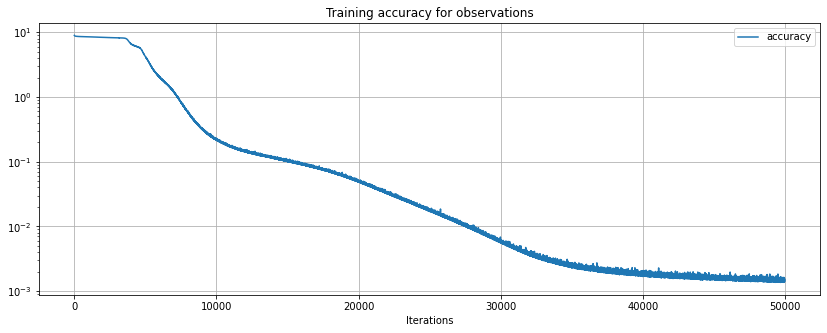

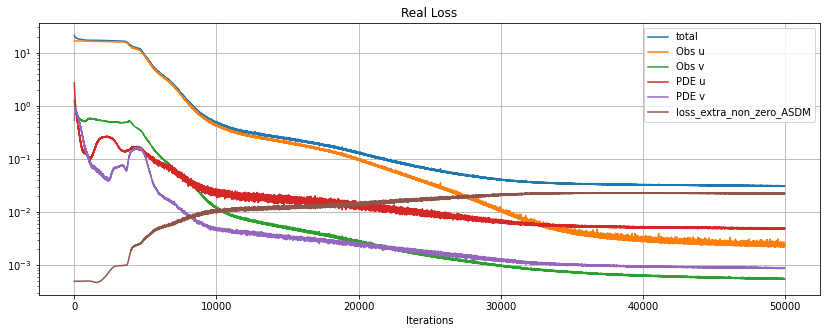

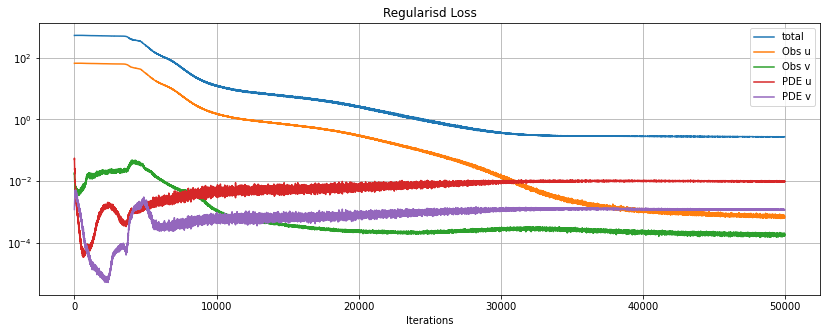

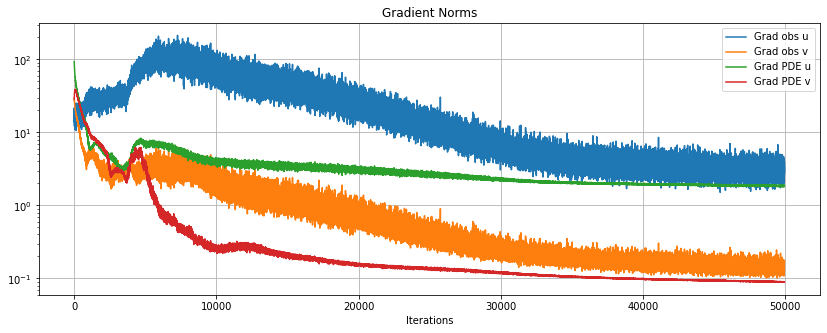

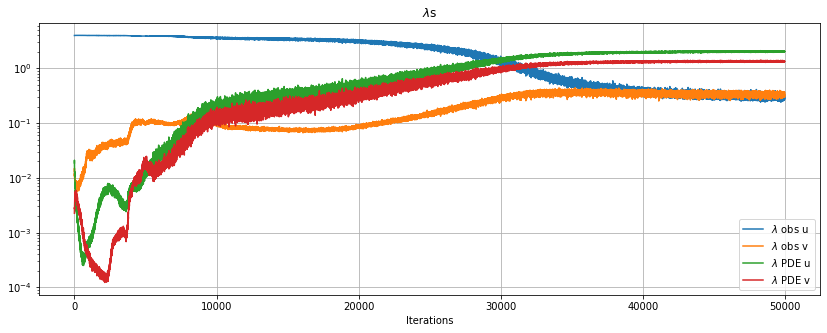

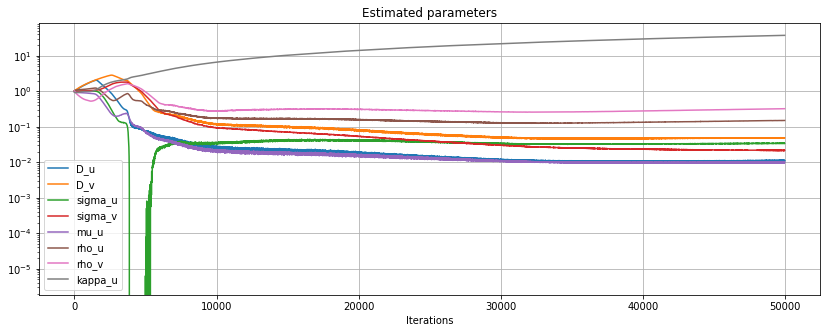

In [94]:
plot_result(results2,
            param_names=pde_loss2.parameter_names(),  
            start=40,
            yscale = 'log')

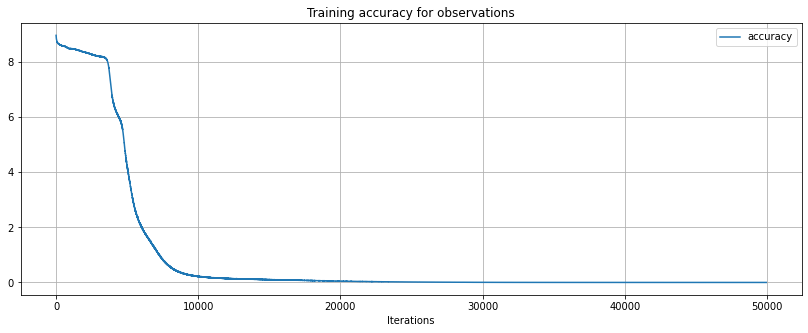

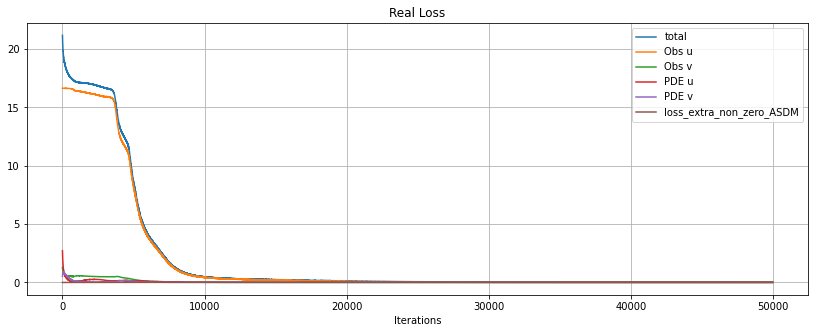

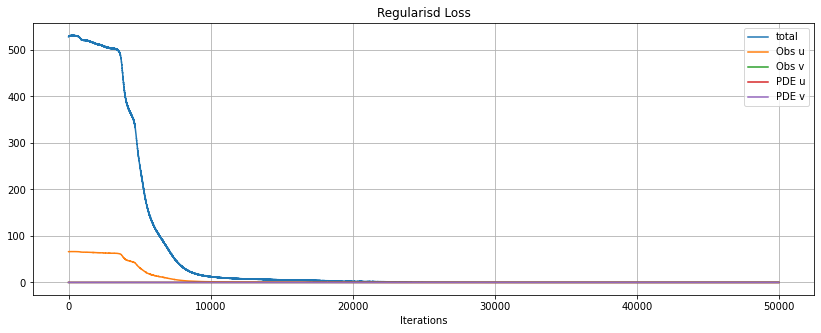

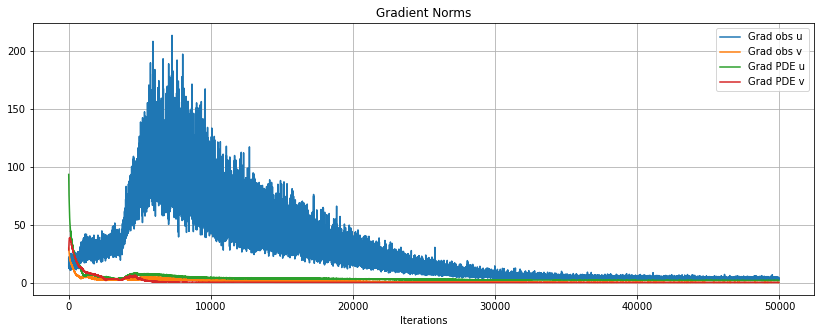

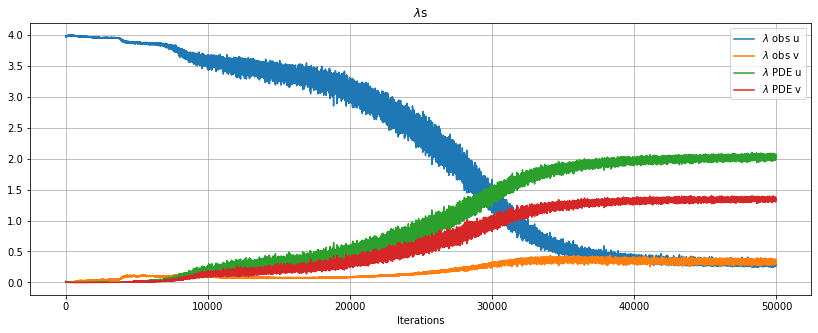

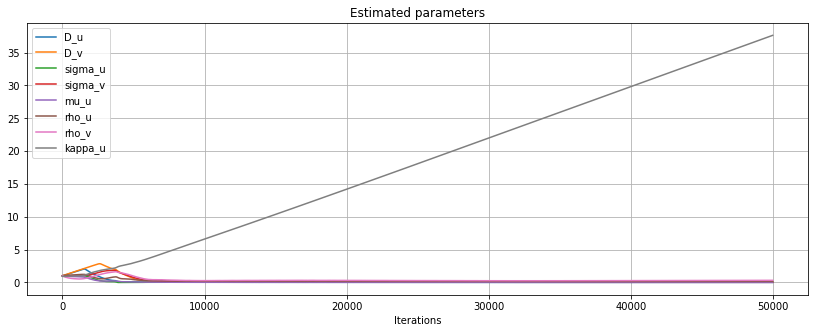

In [95]:
plot_result(results2,
            param_names=pde_loss2.parameter_names(),  
            start=40,
            yscale = 'linear')

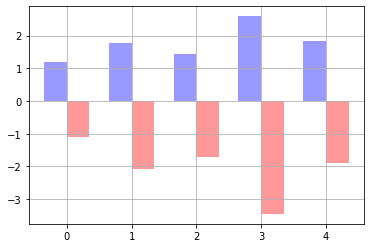

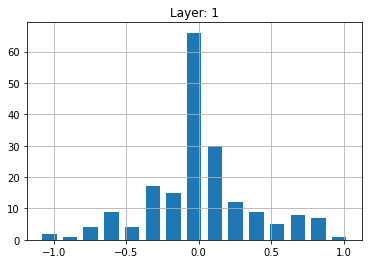

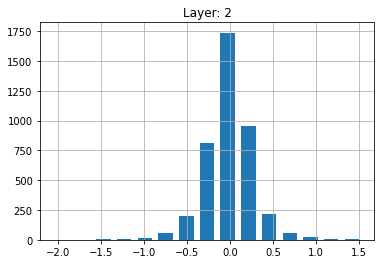

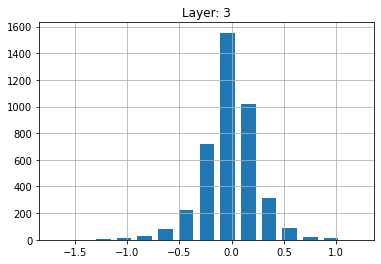

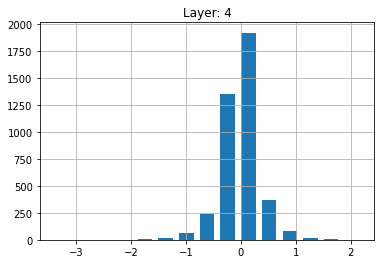

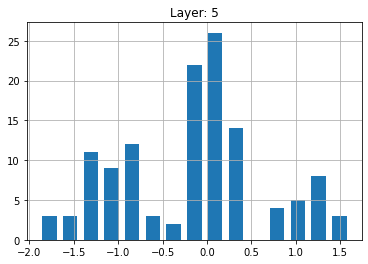

In [96]:
max_ws = np.zeros(len(pinn2.Ws))
min_ws = np.zeros(len(pinn2.Ws))
for i in range(len(pinn2.Ws)):
    max_ws[i] = np.max(pinn2.Ws[i].numpy())
    min_ws[i] = np.min(pinn2.Ws[i].numpy())
    
index = np.arange(len(pinn2.Ws))
bar_width = .35
plt.bar(index , max_ws, bar_width, color='b', alpha = .4)
plt.bar(index + bar_width, min_ws, bar_width, color='r', alpha = .4)

plt.xticks(index + bar_width/2, index)
plt.grid()
plt.show()

for i in range(len(pinn2.Ws)):    
#     if i == 0:
#         bins = np.arange(-1,1,.1)
#     elif i >= 1 and i <=4:
#         bins = np.arange(-1,1,.1)
#     else:
#         bins = np.arange(-.5,0.5,.01)
    max_ws = np.max(pinn2.Ws[i].numpy())
    min_ws = np.min(pinn2.Ws[i].numpy())
    bins = np.arange(min_ws, max_ws, (max_ws - min_ws)/16)
    hists, bins = np.histogram(pinn2.Ws[i].numpy(), bins=bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hists, align='center', width=width)
    plt.grid()
    plt.title(f"Layer: {i+1}")
    plt.show()

20000.0


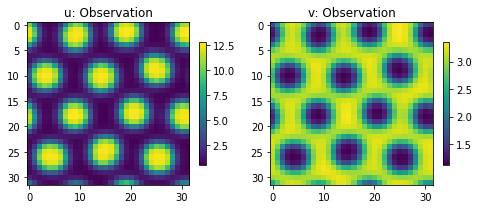

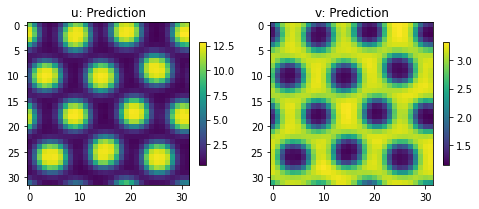

In [98]:
plot_output(pinn2, T_index=-1, s_factor=1)

#### Testing the evaluated parameters

In [99]:
from solvers.explicit_Euler import integrate
from solvers.turing_models import Koch_Meinhardt

In [100]:
n = (32, 32)
L = (32.0, 32.0)

Ds = np.array([pde_loss2.D_u.numpy()[0], pde_loss2.D_v.numpy()[0]])
sigma_u=pde_loss2.sigma_u.numpy()[0]
sigma_v=pde_loss2.sigma_v.numpy()[0]
mu_u=pde_loss2.mu_u.numpy()[0]
rho_u=pde_loss2.rho_u.numpy()[0]
rho_v=pde_loss2.rho_v.numpy()[0]
kappa_u=pde_loss2.kappa_u.numpy()[0]

f_args = (sigma_u, sigma_v, rho_u, rho_v, kappa_u, mu_u)

c0 = data[:,:,:, 0]

t = np.linspace(0, 20000, 256)

dt = 0.1

sol2 = integrate(c0, t, dt, n, L, Ds, Koch_Meinhardt, f_args)

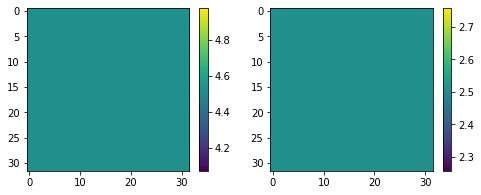

In [101]:
index = -1
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(sol2[0,:,:, index])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(sol2[1,:,:, index])
plt.colorbar(shrink=.75)
plt.show()